# Panel Data Analysis

Authors: Antonio Puzalkov, Gabriele Gabrielli

## Preprocessing

### Load the Data:

In [257]:
import pandas as pd
import unicodedata
import re

price_per_NIL_dict = pd.read_excel("Panel Data/Dati Storici.xlsx", sheet_name=None)
def clean_sheet_prices(sheet):
    sheet["Prezzo m2"] = sheet["Prezzo m2"].str.replace(' €/m2', '', regex=False)
    sheet["Prezzo m2"] = sheet["Prezzo m2"].str.replace('.', '', regex=False)
    sheet["Variazione mensile"] = sheet["Variazione mensile"].str.replace(' %', '', regex=False)
    sheet["Variazione trimestrale"] = sheet["Variazione trimestrale"].str.replace(' %', '', regex=False)
    sheet["Variazione annuale"] = sheet["Variazione annuale"].str.replace(' %', '', regex=False)
    sheet["Variazione mensile"] = sheet["Variazione mensile"].str.replace(' ', '', regex=False)
    sheet["Variazione trimestrale"] = sheet["Variazione trimestrale"].str.replace(' ', '', regex=False)
    sheet["Variazione annuale"] = sheet["Variazione annuale"].str.replace(' ', '', regex=False)
        
    def clean_number_prices(x):
        if isinstance(x, str):
            return float(x.replace(',', '.').replace('+', '').strip())
        return x

    for col in ["Variazione mensile", "Variazione trimestrale", "Variazione annuale"]:
        sheet[col] = sheet[col].apply(clean_number_prices)
    
    sheet["Prezzo m2"] = pd.to_numeric(sheet["Prezzo m2"])
    sheet["Variazione mensile"] = pd.to_numeric(sheet["Variazione mensile"])
    sheet["Variazione trimestrale"] = pd.to_numeric(sheet["Variazione trimestrale"])
    sheet["Variazione annuale"] = pd.to_numeric(sheet["Variazione annuale"])
    return sheet  

for dataset in price_per_NIL_dict.values():
    if "Prezzo m2" in dataset.keys():
        dataset = clean_sheet_prices(dataset)
    else:
        pass

# Converts the dict to a single sheet --> tbd if to be removed or not
all_sheets = []
for name, sheet in price_per_NIL_dict.items():
    if name.lower() == "explanation":
        continue
    
    sheet['NIL'] = name
    sheet = sheet.rename(columns=lambda x: x.split('/n')[-1])
    all_sheets.append(sheet)

prices_full_table = pd.concat(all_sheets)
prices_full_table.reset_index(inplace=True, drop=True)
Legend = pd.read_excel("Panel Data/Legend_updated.xlsx")
prices_full_table = prices_full_table[prices_full_table["NIL"] != "Milano"].copy()
Legend = Legend.drop("Milano", axis=1)
health_care_data = pd.read_csv("Panel Data/Sanità/geocoded_batch_ds683_posti_letto_strutture_milano_final.csv", sep=";", encoding="Latin-1")



In [258]:
health_care_data["ANNO"] = health_care_data["Anno"]
health_remove = ['Tipo Azienda',
 'Codice struttura',
 'Subcodice',
 'Codice tipo struttura',
 'Codice disciplina',
 'Descrizione disciplina',
 'Posti letto Day Surgery',
 'Posti letto Day Hospital',
 'Posti letto degenza a pagamento',
 'Posti letto degenza ordinaria',
 'address_MI',
 'ID_NIL',
 'LONG_X_4326',
 'LAT_Y_4326',
 'Location']

health_keep = ['ANNO',
               "MUNICIPIO",
               "NIL",
               "Totale posti letto",
               "N Reparti",
               ]
health_care_data = health_care_data[health_keep]
inflation = pd.read_excel("Panel Data/Controlli/TassoInflazioneMilano_da_2000.xlsx", header=4).iloc[:,:2]
inflation.rename(columns={"Variazione percentuale tendenziale/n MEDIA ANNUA":"Variazione Annuale"})
cancellazioni_anagrafe = pd.read_excel("Panel Data/Popolazione/CANCELLAZIONI DA ANAGRAFE A MILANO - DATA EVENTO (2004-2022).xlsx")
decessi_anagrafe = pd.read_excel("Panel Data/Popolazione/DECESSI DEI RESIDENTI A MILANO (2003-2023).xlsx")
famiglie_anagrafe = pd.read_csv("Panel Data/Popolazione/FAMIGLIE REGISTRATE IN ANAGRAFE - ANNO.csv", sep=";", encoding='latin-1')
cittadinanza =pd.read_csv("Panel Data/Popolazione/stranieri_storica.csv", sep=";", encoding='latin-1')
popolazione =pd.read_csv("Panel Data/Popolazione/residenti_per-_nil_serie_storica.csv", sep=";", encoding='latin-1')

### Legend Preprocessing

In [259]:
_Legend = Legend.to_dict()
Legend_dict = {}
for key, each in _Legend.items():
    _list = []
    for n in each.values():
        if type(n) == str:
            _list.append(n)
            m = n.split("-")
            for item in m:
                _list.append(item)
    Legend_dict[key]=_list

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Convert abbreviations and handle common variations
    text = text.replace('p.ta', 'porta')
    text = text.replace('pza', 'piazza')
    text = text.replace("citta'", 'citta')
    text = text.replace("citta", 'citta')  # Handle 'citta' without apostrophe
    # Remove accents
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    # Remove special characters (except hyphens)
    text = re.sub(r"[^\w\s-]", '', text)
    # Strip leading/trailing whitespace
    text = text.strip()
    return text



def generate_substrings(nil_normalized):
    substrings = set()
    hyphen_splits = nil_normalized.split('-')
    for part in hyphen_splits:
        part = part.strip()
        substrings.add(part)
        space_splits = part.split()
        for word in space_splits:
            substrings.add(word)
    return substrings


def find_macroarea_from_substrings(nil_normalized):
    substrings = generate_substrings(nil_normalized)
    macroarea_counts = {}
    for substring in substrings:
        if substring in nil_to_macroarea:
            macroarea = nil_to_macroarea[substring]
            macroarea_counts[macroarea] = macroarea_counts.get(macroarea, 0) + 1
    if macroarea_counts:
        # Assign the MacroArea with the highest count
        assigned_macroarea = max(macroarea_counts, key=macroarea_counts.get)
        return assigned_macroarea
    else:
        return None
    
    
nil_to_macroarea = {}
for macroarea, nil_list in Legend_dict.items():
    for nil in nil_list:
        nil_normalized = normalize_text(nil)
        nil_to_macroarea[nil_normalized] = macroarea

        


### Changes in Population

#### Cancellations:

In [260]:
def maiusc(r):
    return r.upper()

cancellazioni_anagrafe.columns = [col.split('(')[0].strip().upper() for col in cancellazioni_anagrafe.columns]
canc_anag = cancellazioni_anagrafe.melt(id_vars='ANNO', var_name='NIL', value_name='VALUE')
canc_anag["ANNO"].astype('int32')
canc_anag = canc_anag[canc_anag["NIL"] != "N.D."]
canc_anag = canc_anag[canc_anag["NIL"] != "TOTALE"]
canc_anag['NIL'] = canc_anag['NIL'].str.strip()


popolazione["ANNO"] = popolazione["Anno"]
popolazione["ANNO"].astype('int32')
popolazione["VALUE"] = popolazione["Residenti"]
popolazione = popolazione.drop(["Anno","Residenti","ID_NIL"],axis=1).copy()

popolazione.columns = [col.strip().upper() for col in popolazione.columns]
popolazione["NIL"] = popolazione["NIL"].apply(maiusc)
popolazione['NIL'] = popolazione['NIL'].str.strip()

popolazione = popolazione[popolazione["ANNO"] > 2010]
canc_anag = canc_anag[canc_anag["ANNO"] > 2010]
canc_anag.rename(columns={'VALUE': 'CANC_VALUE'}, inplace=True)
popolazione.rename(columns={'VALUE': 'POP_VALUE'}, inplace=True)

indep_vars = pd.merge(canc_anag, popolazione, on=['NIL', 'ANNO'])
indep_vars['CANC_RATIO'] = indep_vars['CANC_VALUE'] / indep_vars['POP_VALUE']
indep_vars



,ANNO,NIL,CANC_VALUE,POP_VALUE,CANC_RATIO
0,2011,DUOMO,482.000,17202,0.028020
1,2012,DUOMO,681.000,17218,0.039552
2,2013,DUOMO,1.059,16630,0.000064
3,2014,DUOMO,809.000,16402,0.049323
4,2015,DUOMO,496.000,16634,0.029818
...,...,...,...,...,...
1051,2018,PARCO BOSCO IN CITTA',10.000,596,0.016779
1052,2019,PARCO BOSCO IN CITTA',13.000,633,0.020537
1053,2020,PARCO BOSCO IN CITTA',13.000,645,0.020155
1054,2021,PARCO BOSCO IN CITTA',22.000,672,0.032738


#### Citizenship:

In [261]:
cittadinanza = cittadinanza[cittadinanza["Continente (Italia esclusa)"] != "Apolidi"]
cittadinanza = cittadinanza[cittadinanza["Continente (Italia esclusa)"] != "n.d."]
cittadinanza["NIL"] = cittadinanza["NIL (Nuclei di Identità Locale)"]
cittadinanza["ANNO"] = cittadinanza["Anno"]
cittadinanza["CONTINENTE"] = cittadinanza["Continente (Italia esclusa)"]
cittadinanza["STRANIERI"] = cittadinanza["Residenti stranieri"]
cittadinanza = cittadinanza.drop(["NIL (Nuclei di Identità Locale)","Anno","Continente (Italia esclusa)","Residenti stranieri"], axis=1).copy()
cittadinanza['NIL'] = cittadinanza['NIL'].str.replace(r'\s*\(\d+\)', '', regex=True) 
cittadinanza['CONTINENTE'] = cittadinanza['CONTINENTE'].str.replace('(Italia esclusa)', '', regex=True)
cittadinanza['CONTINENTE'] = cittadinanza['CONTINENTE'].str.replace(r"[^\w\s-]", '', regex=True)
cittadinanza['CONTINENTE'] = cittadinanza['CONTINENTE'].str.replace(' ', '', regex=True)
cittadinanza["NIL"] = cittadinanza["NIL"].apply(maiusc)
cittadinanza["CONTINENTE"] = cittadinanza["CONTINENTE"].apply(maiusc)
cittadinanza.columns = [col.strip().upper() for col in cittadinanza.columns]
cittadinanza['NIL'] = cittadinanza['NIL'].str.strip()

tot_stranieri = cittadinanza.groupby(["NIL","ANNO"]).sum().reset_index().drop("CONTINENTE",axis=1).copy()
stranieri_europei = cittadinanza[cittadinanza['CONTINENTE'] == 'EUROPA']
stranieri_europei = stranieri_europei.groupby(['ANNO', 'NIL'])['STRANIERI'].sum().reset_index()
stranieri_non_europei = cittadinanza[cittadinanza['CONTINENTE'] != 'EUROPA']
stranieri_non_europei = stranieri_non_europei.groupby(['ANNO', 'NIL'])['STRANIERI'].sum().reset_index()
stranieri_non_europei.rename(columns={"STRANIERI":"STRANIERI_NON_EU"}, inplace=True)
stranieri_europei.rename(columns={"STRANIERI":"STRANIERI_EU"}, inplace=True)
indep_vars = pd.merge(indep_vars, stranieri_non_europei, on=['NIL', 'ANNO'])
indep_vars = pd.merge(indep_vars, stranieri_europei, on=['NIL', 'ANNO'])
indep_vars['EU_RATIO'] = indep_vars['STRANIERI_EU'] / indep_vars['POP_VALUE']
indep_vars['NON_EU_RATIO'] = indep_vars['STRANIERI_NON_EU'] / indep_vars['POP_VALUE']


In [262]:
for i in range(0,len(cittadinanza["NIL"].unique())):
    if  sorted(canc_anag["NIL"].unique())[i] in sorted(cittadinanza["NIL"].unique()):
        pass
    else:
        print(False, i,canc_anag["NIL"].unique()[i])


False 53 MUGGIANO


In [263]:
indep_vars

,ANNO,NIL,CANC_VALUE,POP_VALUE,CANC_RATIO,STRANIERI_NON_EU,STRANIERI_EU,EU_RATIO,NON_EU_RATIO
0,2011,DUOMO,482.000,17202,0.028020,1618,877,0.050982,0.094059
1,2012,DUOMO,681.000,17218,0.039552,1634,923,0.053607,0.094901
2,2013,DUOMO,1.059,16630,0.000064,1541,833,0.050090,0.092664
3,2014,DUOMO,809.000,16402,0.049323,1314,732,0.044629,0.080112
4,2015,DUOMO,496.000,16634,0.029818,1285,792,0.047613,0.077251
...,...,...,...,...,...,...,...,...,...
1032,2018,PARCO BOSCO IN CITTA',10.000,596,0.016779,67,82,0.137584,0.112416
1033,2019,PARCO BOSCO IN CITTA',13.000,633,0.020537,73,92,0.145340,0.115324
1034,2020,PARCO BOSCO IN CITTA',13.000,645,0.020155,80,83,0.128682,0.124031
1035,2021,PARCO BOSCO IN CITTA',22.000,672,0.032738,94,82,0.122024,0.139881


#### Families:

In [264]:
famiglie_anagrafe["NIL"] = famiglie_anagrafe["NIL"].str.replace(r'\s*\(\d+\)', '', regex=True)
famiglie_anagrafe["NIL"] = famiglie_anagrafe["NIL"].apply(maiusc)
famiglie_anagrafe['NIL'] = famiglie_anagrafe['NIL'].str.strip()
famiglie_anagrafe.rename(columns={"Anno":"ANNO","Famiglie":"FAMIGLIE"}, inplace=True)
indep_vars = pd.merge(indep_vars, famiglie_anagrafe, on=['NIL', 'ANNO'])
indep_vars['FAM_Ratio'] = indep_vars['FAMIGLIE'] / indep_vars['POP_VALUE']


### INDEP VARS INITIALIZATION:


In [265]:
indep_vars['NIL_normalized'] = indep_vars['NIL'].astype(str).apply(normalize_text)
indep_vars['NIL_normalized'] = indep_vars['NIL'].astype(str).str.strip().str.lower()
indep_vars.loc[indep_vars["NIL_normalized"] == "citta' studi", "NIL_normalized"] = "citta studi"
indep_vars.loc[indep_vars["NIL_normalized"] == "giardini p.ta venezia", "NIL_normalized"] = "giardini porta venezia"
indep_vars.loc[indep_vars["NIL_normalized"] == "parco bosco in citta'", "NIL_normalized"] = "parco bosco in citta"

indep_vars['MacroArea'] = indep_vars['NIL_normalized'].apply(find_macroarea_from_substrings)
indep_vars.keys()

Index(['ANNO', 'NIL', 'CANC_VALUE', 'POP_VALUE', 'CANC_RATIO',
       'STRANIERI_NON_EU', 'STRANIERI_EU', 'EU_RATIO', 'NON_EU_RATIO',
       'FAMIGLIE', 'FAM_Ratio', 'NIL_normalized', 'MacroArea'],
      dtype='object')

In [266]:
indep_vars["NIL_normalized"].unique()

array(['duomo', 'brera', 'giardini porta venezia', 'guastalla',
       'porta vigentina - porta lodovica',
       'porta ticinese - conca del naviglio', 'magenta - s.vittore',
       'porta garibaldi - porta nuova',
       'stazione centrale - ponte seveso', 'isola',
       'maciachini - maggiolina', 'greco - segnano', 'bicocca',
       'gorla - precotto', 'adriano', 'cimiano - rottole - q.re feltre',
       'padova - turro - crescenzago', 'loreto - casoretto - nolo',
       'buenos aires - porta venezia - porta monforte', 'citta studi',
       'lambrate - ortica', 'parco forlanini - cavriano', 'corsica',
       'xxii marzo', 'pta romana', 'umbria - molise - calvairate',
       'ortomercato', 'taliedo - morsenchio - q.re forlanini',
       "monlue' - ponte lambro", 'triulzo superiore',
       'rogoredo - santa giulia', 'chiaravalle', 'lodi - corvetto',
       'scalo romana', 'morivione', 'vigentino - q.re fatima',
       'quintosole', 'ronchetto delle rane',
       'gratosoglio - q.re 

In [267]:
text = 'giardini p.ta venezia'
normalized_text = normalize_text(text)
# After processing:
# text = 'giardini p.ta venezia' (lowercase)
# text = 'giardini porta venezia' (abbreviation replaced)
# text = 'giardini porta venezia' (special characters removed)
normalized_text

'giardini porta venezia'

In [268]:
import pandas as pd

def upsample_to_monthly(data, date_column, value_columns, groupby_columns=None, start_date=None, end_date=None):
    """
    Upsamples a DataFrame from yearly to monthly frequency, extending the series accordingly.
    """
    # Convert date_column to datetime
    data[date_column] = pd.to_datetime(data[date_column].astype(str) + '-01-01')

    # If groupby_columns are specified, group by those columns and date_column, and aggregate
    if groupby_columns:
        data = data.groupby(groupby_columns + [date_column])[value_columns].sum().reset_index()
    else:
        data = data.groupby(date_column)[value_columns].sum().reset_index()

    # Sort data by date
    data = data.sort_values(date_column)

    # Initialize an empty list to hold DataFrames
    dfs = []

    # Group the data
    if groupby_columns:
        groups = data.groupby(groupby_columns)
    else:
        groups = [(None, data)]

    for group_name, group_data in groups:
        # Set date_column as index
        group_data = group_data.set_index(date_column)

        # Determine start and end dates
        min_date = group_data.index.min() if not start_date else pd.to_datetime(start_date)
        max_date = group_data.index.max() if not end_date else pd.to_datetime(end_date)

        # Create a date range from min_date to max_date at monthly frequency
        date_range = pd.date_range(start=min_date, end=max_date, freq='MS')

        # Reindex the data to the new date range
        group_data = group_data.reindex(date_range)

        # Forward-fill the values
        group_data[value_columns] = group_data[value_columns].ffill()

        # Reset index
        group_data = group_data.reset_index().rename(columns={'index': date_column})

        # If groupby_columns are specified, add them back
        if groupby_columns:
            if isinstance(group_name, tuple):
                for col, val in zip(groupby_columns, group_name):
                    group_data[col] = val
            else:
                group_data[groupby_columns[0]] = group_name

        dfs.append(group_data)

    # Concatenate all groups
    result = pd.concat(dfs, ignore_index=True)

    return result

# Assuming 'ValueColumn1', 'ValueColumn2', etc., are the columns you want to upsample
indep_vars_monthly = upsample_to_monthly(
    data=indep_vars,                # Your original data
    date_column='ANNO',             # The column with the date information
    value_columns=['CANC_VALUE', 'POP_VALUE', 'CANC_RATIO',
       'STRANIERI_NON_EU', 'STRANIERI_EU', 'EU_RATIO', 'NON_EU_RATIO',
       'FAMIGLIE', 'FAM_Ratio'],  # Columns to upsample
    groupby_columns=['MacroArea']   # Columns to group by
)

# Display the upsampled DataFrame
indep_vars_monthly.loc[indep_vars_monthly["MacroArea"] == "città Studi-Lambrate", "MacroArea"] = "Città Studi - Lambrate"
indep_vars_monthly


,ANNO,MacroArea,CANC_VALUE,POP_VALUE,CANC_RATIO,STRANIERI_NON_EU,STRANIERI_EU,EU_RATIO,NON_EU_RATIO,FAMIGLIE,FAM_Ratio
0,2011-01-01,Baggio,1594.000,70572.0,0.107863,7770.0,1721.0,0.105674,0.427235,34004.0,2.337714
1,2011-02-01,Baggio,1594.000,70572.0,0.107863,7770.0,1721.0,0.105674,0.427235,34004.0,2.337714
2,2011-03-01,Baggio,1594.000,70572.0,0.107863,7770.0,1721.0,0.105674,0.427235,34004.0,2.337714
3,2011-04-01,Baggio,1594.000,70572.0,0.107863,7770.0,1721.0,0.105674,0.427235,34004.0,2.337714
4,2011-05-01,Baggio,1594.000,70572.0,0.107863,7770.0,1721.0,0.105674,0.427235,34004.0,2.337714
...,...,...,...,...,...,...,...,...,...,...,...
2389,2021-09-01,Città Studi - Lambrate,1057.092,67334.0,0.067636,8047.0,2539.0,0.111512,0.372489,37875.0,1.665536
2390,2021-10-01,Città Studi - Lambrate,1057.092,67334.0,0.067636,8047.0,2539.0,0.111512,0.372489,37875.0,1.665536
2391,2021-11-01,Città Studi - Lambrate,1057.092,67334.0,0.067636,8047.0,2539.0,0.111512,0.372489,37875.0,1.665536
2392,2021-12-01,Città Studi - Lambrate,1057.092,67334.0,0.067636,8047.0,2539.0,0.111512,0.372489,37875.0,1.665536


In [269]:
sorted(list(prices_full_table["NIL"].unique()))
sorted(list(indep_vars_monthly["MacroArea"].unique()))

['Baggio',
 'Centro Storico',
 'Cermenate-Missaglia',
 'Certosa',
 'Città Studi - Lambrate',
 'Comasina-Bicocca',
 'Corvetto-Rogoredo',
 'Famagosta-Barona',
 'Fiera-De Angeli',
 'Forlanini',
 'Garibaldi-Porta Venezia',
 'Greco-Turro',
 'Lorenteggio-Bande Nere',
 'Navigli-Bocconi',
 'Porta Vittoria',
 'San Siro-Trenno-Figino',
 'Vialba-Gallaratese',
 'Vigentino-Ripamonti']

### HealthCare Preprocessing

In [270]:

health_care_data['NIL_normalized'] = health_care_data['NIL'].astype(str).apply(normalize_text)
health_care_data['NIL_normalized'] = health_care_data['NIL'].astype(str).str.strip().str.lower()
health_care_data['MacroArea'] = health_care_data['NIL_normalized'].map(nil_to_macroarea)

mask = health_care_data['MacroArea'].isna()
health_care_data.loc[mask, 'MacroArea'] = health_care_data.loc[mask, 'NIL_normalized'].apply(find_macroarea_from_substrings)


In [271]:
def create_cumulative_beds_monthly(health_care_data):
    health_care_data['ANNO'] = health_care_data['ANNO'].astype(int)
    grouped = health_care_data.groupby(['MacroArea', 'ANNO'])['Totale posti letto'].sum().reset_index()
    
    # Create a date range from 2010-01-01 to 2024-07-01 at monthly frequency
    date_range = pd.date_range(start='2010-01-01', end='2024-07-01', freq='MS')
    
    dfs = []
    
    for macro_area in grouped['MacroArea'].unique():
        macro_area_data = grouped[grouped['MacroArea'] == macro_area]
        macro_area_data['Date'] = pd.to_datetime(macro_area_data['ANNO'].astype(str) + '-01-01')
        macro_area_data = macro_area_data.sort_values('Date')
        macro_area_data['Cumulative Beds'] = macro_area_data['Totale posti letto'].cumsum()
        macro_area_data.set_index('Date', inplace=True)
        
        df_full = macro_area_data.reindex(date_range)
        df_full['Cumulative Beds'] = df_full['Cumulative Beds'].ffill()
        df_full['Cumulative Beds'].fillna(0, inplace=True)
        df_full['MacroArea'] = macro_area
        df_full.reset_index(inplace=True)
        df_full.rename(columns={'index': 'Date'}, inplace=True)
        df_full = df_full[['Date', 'MacroArea', 'Cumulative Beds']]
        dfs.append(df_full)
    
    result_df = pd.concat(dfs, ignore_index=True)
    return result_df

# Use the modified function
Sanità_totale = create_cumulative_beds_monthly(health_care_data)

Sanità_totale



C:\Users\apuza\AppData\Local\Temp\ipykernel_9392\1622751488.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macro_area_data['Date'] = pd.to_datetime(macro_area_data['ANNO'].astype(str) + '-01-01')
C:\Users\apuza\AppData\Local\Temp\ipykernel_9392\1622751488.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace o

,Date,MacroArea,Cumulative Beds
0,2010-01-01,Baggio,730.0
1,2010-02-01,Baggio,730.0
2,2010-03-01,Baggio,730.0
3,2010-04-01,Baggio,730.0
4,2010-05-01,Baggio,730.0
...,...,...,...
2445,2024-03-01,città Studi-Lambrate,11040.0
2446,2024-04-01,città Studi-Lambrate,11040.0
2447,2024-05-01,città Studi-Lambrate,11040.0
2448,2024-06-01,città Studi-Lambrate,11040.0


In [272]:
import pandas as pd

def create_cumulative_beds_monthly(health_care_data):
    # Ensure 'ANNO' is of integer type
    health_care_data['ANNO'] = health_care_data['ANNO'].astype(int)
    
    # Filter data to include only years from 2012 onwards
    health_care_data = health_care_data[health_care_data['ANNO'] >= 2012]
    
    # Group the data by 'MacroArea' and 'ANNO', taking the maximum 'Totale posti letto' per year
    grouped = health_care_data.groupby(['MacroArea', 'ANNO'])['Totale posti letto'].max().reset_index()
    
    # Sort the grouped data by 'MacroArea' and 'ANNO'
    grouped = grouped.sort_values(['MacroArea', 'ANNO'])
    
    # Compute the beds added each year by calculating the difference from the previous year
    grouped['Beds Added'] = grouped.groupby('MacroArea')['Totale posti letto'].diff().fillna(grouped['Totale posti letto'])
    
    # Create the cumulative sum of beds added each year
    grouped['Cumulative Beds'] = grouped.groupby('MacroArea')['Beds Added'].cumsum()
    
    # Create a date range from 2010-01-01 to 2024-07-01 at monthly frequency
    date_range = pd.date_range(start='2010-01-01', end='2024-07-01', freq='MS')
    
    # Initialize an empty list to store DataFrames for each MacroArea
    dfs = []
    
    for macro_area in grouped['MacroArea'].unique():
        # Filter data for the current MacroArea
        macro_area_data = grouped[grouped['MacroArea'] == macro_area]
        
        # Create a DataFrame with dates at the start of each year and the corresponding cumulative beds
        macro_area_data['Date'] = pd.to_datetime(macro_area_data['ANNO'].astype(str) + '-01-01')
        macro_area_data = macro_area_data[['Date', 'MacroArea', 'Cumulative Beds']]
        macro_area_data.set_index('Date', inplace=True)
        
        # Reindex to the full monthly date range
        df_full = macro_area_data.reindex(date_range)
        
        # Forward-fill the cumulative beds
        df_full['Cumulative Beds'] = df_full['Cumulative Beds'].ffill()
        
        # Before any beds are added, cumulative beds should be 0
        df_full['Cumulative Beds'].fillna(0, inplace=True)
        
        # Add the MacroArea column
        df_full['MacroArea'] = macro_area
        
        # Reset index to turn the Date index into a column
        df_full.reset_index(inplace=True)
        df_full.rename(columns={'index': 'Date'}, inplace=True)
        
        # Keep only the necessary columns
        df_full = df_full[['Date', 'MacroArea', 'Cumulative Beds']]
        
        # Append the DataFrame to the list
        dfs.append(df_full)
    
    # Concatenate all MacroArea DataFrames
    result_df = pd.concat(dfs, ignore_index=True)
    
    return result_df

# Use the modified function
Sanità_relativa = create_cumulative_beds_monthly(health_care_data)
Sanità_relativa.loc[Sanità_relativa["MacroArea"] == "città Studi-Lambrate", "MacroArea"] = "Città Studi - Lambrate"


# Display the first few rows
Sanità_relativa


C:\Users\apuza\AppData\Local\Temp\ipykernel_9392\3390014534.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macro_area_data['Date'] = pd.to_datetime(macro_area_data['ANNO'].astype(str) + '-01-01')
C:\Users\apuza\AppData\Local\Temp\ipykernel_9392\3390014534.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace o

,Date,MacroArea,Cumulative Beds
0,2010-01-01,Baggio,0.0
1,2010-02-01,Baggio,0.0
2,2010-03-01,Baggio,0.0
3,2010-04-01,Baggio,0.0
4,2010-05-01,Baggio,0.0
...,...,...,...
2445,2024-03-01,Città Studi - Lambrate,130.0
2446,2024-04-01,Città Studi - Lambrate,130.0
2447,2024-05-01,Città Studi - Lambrate,130.0
2448,2024-06-01,Città Studi - Lambrate,130.0


### Final Merge

In [273]:
import pandas as pd
import numpy as np

def add_missing_macroareas(sanita_df, prices_df):
    """
    Adds missing MacroAreas to sanita_df with 'Cumulative Beds' set to 0.

    Parameters:
    - sanita_df: DataFrame containing 'Date', 'MacroArea', 'Cumulative Beds'.
    - prices_df: DataFrame containing 'NIL' or 'MacroArea' to compare.

    Returns:
    - sanita_updated: DataFrame with missing MacroAreas added.
    """

    # Step 1: Identify missing MacroAreas
    sanita_macroareas = sanita_df['MacroArea'].unique()
    prices_macroareas = prices_df['NIL'].unique()  # Adjust if the column name is different

    # Normalize the names to ensure consistency
    def normalize_name(name):
        return name.strip().lower()

    sanita_macroareas_norm = set(normalize_name(ma) for ma in sanita_macroareas)
    prices_macroareas_norm = set(normalize_name(ma) for ma in prices_macroareas)

    # Map normalized names back to original names
    sanita_macroarea_map = {normalize_name(ma): ma for ma in sanita_macroareas}
    prices_macroarea_map = {normalize_name(ma): ma for ma in prices_macroareas}

    # Find MacroAreas present in prices but not in sanita
    missing_macroareas_norm = prices_macroareas_norm - sanita_macroareas_norm

    # Use original names of missing MacroAreas
    missing_macroareas = [prices_macroarea_map[ma_norm] for ma_norm in missing_macroareas_norm]

    # Step 2: Get the date range from sanita_df
    date_range = sanita_df['Date'].unique()
    date_range = np.sort(date_range)

    # Create a DataFrame for each missing MacroArea
    dfs = []
    for macro_area in missing_macroareas:
        df = pd.DataFrame({
            'Date': date_range,
            'MacroArea': macro_area,
            'Cumulative Beds': 0
        })
        dfs.append(df)

    # Step 3: Append these DataFrames to sanita_df
    sanita_updated = pd.concat([sanita_df] + dfs, ignore_index=True)

    return sanita_updated

# Assuming Sanità_relativa and prices_full_table are your DataFrames
Sanità_relativa = add_missing_macroareas(Sanità_relativa, prices_full_table)

# Verify that all MacroAreas from prices_full_table are now present
print(Sanità_relativa['MacroArea'].unique())


['Baggio' 'Centro Storico' 'Certosa' 'Comasina-Bicocca'
 'Corvetto-Rogoredo' 'Famagosta-Barona' 'Fiera-De Angeli' 'Forlanini'
 'Garibaldi-Porta Venezia' 'Greco-Turro' 'Navigli-Bocconi'
 'Porta Vittoria' 'San Siro-Trenno-Figino' 'Città Studi - Lambrate'
 'Cermenate-Missaglia' 'Lorenteggio-Bande Nere' 'Vialba-Gallaratese'
 'Vigentino-Ripamonti']


In [274]:
prices_full_table.rename(columns={"NIL":"MacroArea","Mese":"Date"}, inplace=True)
indep_vars_monthly.rename(columns={"ANNO":"Date"}, inplace=True)
tot_table = pd.merge(prices_full_table,indep_vars_monthly, on=["Date","MacroArea"])
tot_table_ = tot_table.copy()



### Distances

In [275]:
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np

areas = sorted(list(tot_table["MacroArea"].unique()))

# Initialize geolocator
geolocator = Nominatim(user_agent="milan_distance_matrix")

# Dictionary to store coordinates
area_coordinates = {}

# Loop through each area and get coordinates
for area in areas:
    try:
        location = geolocator.geocode(f"{area}, Milan, Italy")
        if location:
            area_coordinates[area] = (location.latitude, location.longitude)
        else:
            print(f"Could not find coordinates for {area}")
    except Exception as e:
        print(f"Error retrieving coordinates for {area}: {e}")
from geopy.distance import geodesic

# Initialize an empty DataFrame to store distances
distance_matrix = pd.DataFrame(index=areas, columns=areas)

area_coordinates.update({
    "Cermenate-Missaglia": (45.4175, 9.1758),
    "Comasina-Bicocca": (45.5291, 9.1643),
    "Corvetto-Rogoredo": (45.4342, 9.2389),
    "Garibaldi-Porta Venezia": (45.4804, 9.1987),
    "Navigli-Bocconi": (45.4491, 9.1812),
    "San Siro-Trenno-Figino": (45.4783, 9.1238)
})

# Loop through each pair of areas to compute distances
for area1 in areas:
    for area2 in areas:
        if area1 == area2:
            distance = 0.0  # Distance to self is zero
        else:
            coords_1 = area_coordinates.get(area1)
            coords_2 = area_coordinates.get(area2)
            if coords_1 and coords_2:
                # Calculate the geodesic distance
                distance = geodesic(coords_1, coords_2).kilometers
            else:
                distance = np.nan  # Assign NaN if coordinates are missing
        distance_matrix.loc[area1, area2] = distance

# Convert distance values to numeric
distance_matrix = distance_matrix.apply(pd.to_numeric)
distance_matrix



Could not find coordinates for Cermenate-Missaglia
Could not find coordinates for Comasina-Bicocca
Could not find coordinates for Corvetto-Rogoredo
Could not find coordinates for Garibaldi-Porta Venezia
Could not find coordinates for Navigli-Bocconi
Could not find coordinates for San Siro-Trenno-Figino


,Baggio,Centro Storico,Cermenate-Missaglia,Certosa,Città Studi - Lambrate,Comasina-Bicocca,Corvetto-Rogoredo,Famagosta-Barona,Fiera-De Angeli,Forlanini,Garibaldi-Porta Venezia,Greco-Turro,Lorenteggio-Bande Nere,Navigli-Bocconi,Porta Vittoria,San Siro-Trenno-Figino,Vialba-Gallaratese,Vigentino-Ripamonti
Baggio,0.000000,7.546697,8.307779,14.974956,12.234118,9.513829,12.045801,6.702318,4.655023,12.065326,8.770877,9.763428,3.900820,7.275188,9.176017,3.253610,7.022513,9.904945
Centro Storico,7.546697,0.000000,5.589609,9.036393,4.977284,7.076472,5.536998,3.654730,3.147976,4.591015,1.765284,3.983701,4.265180,2.054823,1.747618,5.013654,6.999360,5.225990
Cermenate-Missaglia,8.307779,5.589609,0.000000,7.124201,9.516760,12.435893,5.275521,2.236847,6.642580,7.247401,7.216626,9.545649,4.731358,3.537360,5.548791,7.887334,11.620164,2.208069
Certosa,14.974956,9.036393,7.124201,0.000000,9.230619,15.572082,3.544544,8.274280,11.798875,6.125592,9.556354,11.513912,11.090183,8.013526,7.531619,13.551358,16.010516,5.117780
Città Studi - Lambrate,12.234118,4.977284,9.516760,9.230619,0.000000,7.417357,6.180646,8.188525,7.583932,3.148916,3.468215,3.396275,9.237349,6.505811,4.043896,9.251759,9.080516,8.103743
Comasina-Bicocca,9.513829,7.076472,12.435893,15.572082,7.417357,0.000000,12.052525,10.252845,6.312323,9.761721,6.043490,4.189743,9.020112,8.988922,8.147187,6.472689,2.869579,12.301789
Corvetto-Rogoredo,12.045801,5.536998,5.275521,3.544544,6.180646,12.052525,0.000000,5.545369,8.437326,3.066088,6.020959,8.053756,8.159379,4.808524,3.988040,10.250659,12.478895,3.103274
Famagosta-Barona,6.702318,3.654730,2.236847,8.274280,8.188525,10.252845,5.545369,0.000000,4.415834,6.544634,5.394583,7.629884,2.842833,1.699118,4.157422,5.762544,9.384577,3.219862
Fiera-De Angeli,4.655023,3.147976,6.642580,11.798875,7.583932,6.312323,8.437326,4.415834,0.000000,7.731682,4.130189,5.246690,2.711502,3.835356,4.890409,1.867318,4.994900,7.260355
Forlanini,12.065326,4.591015,7.247401,6.125592,3.148916,9.761721,3.066088,6.544634,7.731682,0.000000,4.123232,5.584225,8.462164,5.111325,2.890914,9.590653,10.759642,5.442764


In [276]:
areas

['Baggio',
 'Centro Storico',
 'Cermenate-Missaglia',
 'Certosa',
 'Città Studi - Lambrate',
 'Comasina-Bicocca',
 'Corvetto-Rogoredo',
 'Famagosta-Barona',
 'Fiera-De Angeli',
 'Forlanini',
 'Garibaldi-Porta Venezia',
 'Greco-Turro',
 'Lorenteggio-Bande Nere',
 'Navigli-Bocconi',
 'Porta Vittoria',
 'San Siro-Trenno-Figino',
 'Vialba-Gallaratese',
 'Vigentino-Ripamonti']

In [277]:
area_coordinates.update({
    "Cermenate-Missaglia": (45.4280, 9.1857),
    "Comasina-Bicocca": (45.5225, 9.1924),
    "Corvetto-Rogoredo": (45.4360, 9.2388),
    "Garibaldi-Porta Venezia": (45.4773, 9.1946),
    "Navigli-Bocconi": (45.4504, 9.1829),
    "San Siro-Trenno-Figino": (45.4860, 9.1040)
})
area_coordinates

{'Baggio': (45.4613839, 9.089843),
 'Centro Storico': (45.467280599999995, 9.185974407770392),
 'Certosa': (45.4086119, 9.2659321),
 'Città Studi - Lambrate': (45.4897912, 9.241006048344573),
 'Famagosta-Barona': (45.4368888, 9.1681331),
 'Fiera-De Angeli': (45.47366125, 9.146753149999999),
 'Forlanini': (45.4615428, 9.2441085),
 'Greco-Turro': (45.5015516, 9.200902108152167),
 'Lorenteggio-Bande Nere': (45.4502239, 9.1371252),
 'Porta Vittoria': (45.4622795, 9.2071602),
 'Vialba-Gallaratese': (45.5173235, 9.1316131),
 'Vigentino-Ripamonti': (45.421872, 9.2033197),
 'Cermenate-Missaglia': (45.428, 9.1857),
 'Comasina-Bicocca': (45.5225, 9.1924),
 'Corvetto-Rogoredo': (45.436, 9.2388),
 'Garibaldi-Porta Venezia': (45.4773, 9.1946),
 'Navigli-Bocconi': (45.4504, 9.1829),
 'San Siro-Trenno-Figino': (45.486, 9.104)}

#### MODEL:

#### Each area on its own with StateSpace

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents

# Ensure that Date columns are datetime objects
tot_table['Date'] = pd.to_datetime(tot_table['Date'])
Sanità_relativa['Date'] = pd.to_datetime(Sanità_relativa['Date'])

# Merge Sanità_relativa into tot_table
Sanità_relativa.rename(columns={'Date': 'Date', 'MacroArea': 'MacroArea'}, inplace=True)
tot_table = pd.merge(tot_table, Sanità_relativa, on=['Date', 'MacroArea'], how='left')

# Fill missing values in 'Cumulative Beds' with 0
tot_table['Cumulative Beds'] = tot_table['Cumulative Beds'].fillna(0)

# List of independent variables
exog_vars = ['Cumulative Beds', 'CANC_RATIO', 'EU_RATIO', 'NON_EU_RATIO', 'FAM_Ratio']

# Ensure there are no missing values in the exogenous variables
tot_table[exog_vars] = tot_table[exog_vars].fillna(method='ffill').fillna(method='bfill')

# Create an empty list to store results
model_results = []

# Loop over each MacroArea
for macro_area in tot_table['MacroArea'].unique():
    # Subset the data for the macro_area
    df = tot_table[tot_table['MacroArea'] == macro_area].copy()
    # Ensure data is sorted by Date
    df.sort_values('Date', inplace=True)
    # Set the index to Date
    df.set_index('Date', inplace=True)
    # Dependent variable
    endog = df['Prezzo m2']
    # Exogenous variables
    exog = df[exog_vars]
    
    # Check if there are enough data points
    if len(endog) < 10:
        print(f"Not enough data for MacroArea: {macro_area}. Skipping.")
        continue
    
    # Fit the Unobserved Components Model
    try:
        mod = UnobservedComponents(endog, level='llevel', exog=exog)
        res = mod.fit(disp=False)
        # Store the results
        model_results.append((macro_area, res))
        print(f"Model fitted for MacroArea: {macro_area}")
    except Exception as e:
        print(f"Error fitting model for MacroArea: {macro_area}. Error: {e}")

# Display the summary for each model
for macro_area, res in model_results:
    print(f"\nMacroArea: {macro_area}")
    print(res.summary())


C:\Users\apuza\AppData\Local\Temp\ipykernel_9392\1881941571.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tot_table[exog_vars] = tot_table[exog_vars].fillna(method='ffill').fillna(method='bfill')
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitted for MacroArea: Forlanini
Model fitted for MacroArea: Garibaldi-Porta Venezia
Model fitted for MacroArea: Greco-Turro
Model fitted for MacroArea: Lorenteggio-Bande Nere


C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitted for MacroArea: Navigli-Bocconi
Model fitted for MacroArea: Porta Vittoria
Model fitted for MacroArea: San Siro-Trenno-Figino
Model fitted for MacroArea: Vialba-Gallaratese


C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitted for MacroArea: Vigentino-Ripamonti
Model fitted for MacroArea: Corvetto-Rogoredo
Model fitted for MacroArea: Famagosta-Barona


C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitted for MacroArea: Certosa
Model fitted for MacroArea: Comasina-Bicocca
Model fitted for MacroArea: Città Studi - Lambrate
Model fitted for MacroArea: Cermenate-Missaglia


C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitted for MacroArea: Baggio
Model fitted for MacroArea: Centro Storico
Model fitted for MacroArea: Fiera-De Angeli

MacroArea: Forlanini
                        Unobserved Components Results                         
Dep. Variable:              Prezzo m2   No. Observations:                  121
Model:                    local level   Log Likelihood                -668.975
Date:                Wed, 18 Sep 2024   AIC                           1351.951
Time:                        17:39:58   BIC                           1371.463
Sample:                    01-01-2012   HQIC                          1359.875
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
sigma2.irregular         0.0075    318.933   2

C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Fixed Effect Model

In [279]:
import pandas as pd
import numpy as np
from libpysal.weights import DistanceBand
from spreg import Panel_FE_Lag

# Assuming you have the coordinates for each MacroArea
coordinates = pd.DataFrame.from_dict(area_coordinates, orient='index', columns=['latitude', 'longitude'])
coordinates.reset_index(inplace=True)
coordinates.rename(columns={'index': 'MacroArea'}, inplace=True)
coordinates_ = coordinates.copy()

# Merge coordinates with your main data
tot_table = tot_table.merge(coordinates, on='MacroArea', how='left')

# Extract coordinates
coords = list(zip(tot_table['longitude'], tot_table['latitude']))

# Create distance-based spatial weights (e.g., within 10 km)
w = DistanceBand(coords, threshold=10, binary=True)
# Reset index if necessary
tot_table = tot_table.reset_index()

# Ensure Date is in datetime format
tot_table['Date'] = pd.to_datetime(tot_table['Date'])

# Sort the data
tot_table.sort_values(['MacroArea', 'Date'], inplace=True)
# Dependent variable
y_wide = tot_table.pivot(index='MacroArea', columns='Date', values='Prezzo m2')

# Independent variables
X_wide = {}
for var in exog_vars:
    X_wide[var] = tot_table.pivot(index='MacroArea', columns='Date', values=var)
import numpy as np

# Convert y_wide to a NumPy array
y_array = y_wide.values  # Shape: (n_entities, n_time_periods)

# Stack X variables into a 3D array
X_array = np.array([X_wide[var].values for var in exog_vars])  # Shape: (n_vars, n_entities, n_time_periods)

# Rearrange X_array to match expected shape
X_array = X_array.transpose(1, 2, 0)  # Shape: (n_entities, n_time_periods, n_vars)
# Get dimensions
N, T = y_array.shape  # N: number of entities, T: number of time periods

# Flatten y and X
y_flat = y_array.flatten(order='F').reshape(-1, 1)  # Shape: (N*T, 1)

# Flatten X
X_flat = X_array.reshape(N*T, -1, order='F')  # Shape: (N*T, n_vars)
from libpysal.weights import DistanceBand

# Get the coordinates in the order of y_wide index
coords_ordered = coordinates.set_index('MacroArea').loc[y_wide.index][['latitude', 'longitude']].values

# Create the spatial weights matrix
w = DistanceBand(coords_ordered, threshold=10, binary=True, silence_warnings=True)
w.transform = 'r'  # Row-standardization


In [280]:
from spreg.panel_fe import Panel_FE_Lag

model = Panel_FE_Lag(
    y=y_flat,
    x=X_flat,
    w=w,
    name_y='Prezzo m2',
    name_x=exog_vars
)

print(model.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG PANEL - FIXED EFFECTS
-----------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   Prezzo m2                Number of Observations:        2178
Mean dependent var  :      0.0000                Number of Variables   :           6
S.D. dependent var  :    427.8882                Degrees of Freedom    :        2172
Pseudo R-squared    :      0.7736
Spatial Pseudo R-squared:  0.0025
Sigma-square ML     :   43386.864                Log likelihood        :  -23236.160
S.E of regression   :     208.295                Akaike info criterion :   46484.319
                                                 Schwarz criterion     :   46518.436

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------

#### BVAR:

In [295]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pymc as pm
import aesara.tensor as at
import aesara
from libpysal.weights import DistanceBand
import matplotlib.pyplot as plt
import arviz as az

# Step 1: Data Preparation

# Assuming you have your data in 'tot_table' DataFrame with 'MacroArea', 'Date', and variables
tot_table = tot_table_.copy()
coordinates = coordinates_.copy()
variables = ['Prezzo m2', 'CANC_RATIO', 'EU_RATIO', 'NON_EU_RATIO', 'FAM_Ratio']

# Reset index if necessary
tot_table = tot_table.reset_index(drop=True)

# Ensure 'Date' is in datetime format
tot_table['Date'] = pd.to_datetime(tot_table['Date'])

# Sort data by 'Date' and 'MacroArea'
tot_table.sort_values(['Date', 'MacroArea'], inplace=True)

# Create a MultiIndex with 'Date' and 'MacroArea'
tot_table.set_index(['Date', 'MacroArea'], inplace=True)

# Pivot the data to create a 3D array
data_pivot = tot_table[variables].unstack(level='MacroArea')

# Get the list of MacroAreas in the order of data_pivot columns
macroareas = data_pivot.columns.levels[1]

# Convert data_pivot to a NumPy array
Y_array = data_pivot.values  # Shape: (n_time_periods, n_macroareas * n_variables)

# Get dimensions
n_time_periods = data_pivot.shape[0]
n_macroareas = len(macroareas)
n_variables = len(variables)

# Reshape Y_array to (n_time_periods, n_macroareas, n_variables)
Y = Y_array.reshape(n_time_periods, n_macroareas, n_variables)

# Handle missing values (e.g., forward fill)
Y = pd.DataFrame(Y.reshape(n_time_periods, -1)).ffill().values.reshape(n_time_periods, n_macroareas, n_variables)

# Create lagged variables
p = 1  # Number of lags

# Y_lagged: shape (n_time_periods - p, n_macroareas, n_variables)
Y_lagged = Y[:-p]
Y_target = Y[p:]

# Update n_time_periods to reflect the new length
n_time_periods = Y_target.shape[0]

# Step 2: Create Spatial Weights Matrix

# Ensure that the MacroAreas are in the same order as in 'macroareas'
coordinates.set_index('MacroArea', inplace=True)
coordinates_ordered = coordinates.loc[macroareas].reset_index()

# Extract coordinates as NumPy array
coords = coordinates_ordered[['latitude', 'longitude']].values

# Create the spatial weights matrix using DistanceBand
w = DistanceBand(coords, threshold=10, binary=True, silence_warnings=True)
w.transform = 'r'  # Row-standardization

# Convert weights to a dense NumPy array
W_sparse, ids = w.full()
W = W_sparse  # W_sparse is already a dense NumPy array





In [296]:
with pm.Model() as model:
    # Priors for VAR coefficients
    A = pm.Normal('A', mu=0, sigma=1, shape=(n_variables, n_variables))

    # Spatial autoregressive parameter
    rho = pm.Uniform('rho', lower=-1, upper=1)

    # Error standard deviations for each variable
    sigma_u = pm.HalfNormal('sigma_u', sigma=1, shape=(n_variables,))

    # Observed data
    Y_obs = pm.MutableData('Y_obs', Y_target)
    Y_lag = pm.MutableData('Y_lag', Y_lagged)
    W_data = pm.ConstantData('W', W)  # Use W as a constant since it doesn't change

    # Reshape Y_lag for dot product
    Y_lag_reshaped = Y_lag.reshape((n_time_periods * n_macroareas, n_variables))

    # Compute mu_t
    mu_t = pm.math.dot(Y_lag_reshaped, A.T)
    mu_t = mu_t.reshape((n_time_periods, n_macroareas, n_variables))

    # Compute spatial lag by looping over variables
    WY_list = []
    for k in range(n_variables):
        Y_obs_k = Y_obs[:, :, k]  # Shape: (n_time_periods, n_macroareas)
        WY_k = at.dot(Y_obs_k, W_data)  # Shape: (n_time_periods, n_macroareas)
        WY_list.append(WY_k)

    # Stack WY_k along the third axis
    WY = at.stack(WY_list, axis=2)  # Shape: (n_time_periods, n_macroareas, n_variables)

    # Compute spatial term
    spatial_term = rho * WY

    # Total expected value
    expected = mu_t + spatial_term

    # Observation equation
    Y = pm.Normal('Y', mu=expected, sigma=sigma_u, observed=Y_obs)

# Model fitting
with model:
    # Optionally, print shapes to verify
    print("Y_obs shape:", Y_obs.eval().shape)
    print("Y_lag shape:", Y_lag.eval().shape)
    print("W_data shape:", W_data.eval().shape)
    print("mu_t shape:", mu_t.eval().shape)
    print("WY shape:", WY.eval().shape)
    print("expected shape:", expected.eval().shape)

    # Sample from the posterior
    trace = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True
    )

# Results interpretation
print(az.summary(trace, var_names=['A', 'rho', 'sigma_u']))

az.plot_trace(trace, var_names=['A', 'rho', 'sigma_u'])
plt.show()

C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


NotImplementedError: Cannot convert Subtensor{:, :, i}.0 to a tensor variable.

#### VAR

In [313]:
prices_full_table

,Date,Prezzo m2,Variazione mensile,Variazione trimestrale,Variazione annuale,MacroArea
151,2024-07-01,4466,1.4,-1.2,3.1,Forlanini
152,2024-06-01,4406,-2.3,-2.2,1.5,Forlanini
153,2024-05-01,4507,-0.3,1.9,4.2,Forlanini
154,2024-04-01,4521,0.3,3.3,5.8,Forlanini
155,2024-03-01,4506,1.9,3.5,4.5,Forlanini
...,...,...,...,...,...,...
2864,2012-05-01,5200,1.1,2.0,NaN,Fiera-De Angeli
2865,2012-04-01,5146,-0.3,1.8,NaN,Fiera-De Angeli
2866,2012-03-01,5160,1.2,NaN,NaN,Fiera-De Angeli
2867,2012-02-01,5098,0.9,NaN,NaN,Fiera-De Angeli


In [321]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson

# Load the datasets
prices_df = prices_full_table[["Date", "MacroArea", "Prezzo m2"]]
coords_df = coordinates_

# Merge datasets based on MacroArea
merged_df = pd.merge(prices_df, coords_df, on='MacroArea')

# Ensure 'Date' column is of datetime type
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Fill missing 'Prezzo m2' values with interpolation (if needed)
merged_df['Prezzo m2'] = merged_df.groupby('MacroArea')['Prezzo m2'].transform(lambda x: x.interpolate())

# Create a spatial weights matrix based on geographical distances
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

# Get unique MacroAreas
unique_macroareas = merged_df['MacroArea'].unique()

# Create an empty spatial weights matrix
spatial_weights = np.zeros((len(unique_macroareas), len(unique_macroareas)))

# Populate the spatial weights matrix
for i, area_i in enumerate(unique_macroareas):
    lat_i = merged_df.loc[merged_df['MacroArea'] == area_i, 'latitude'].values[0]
    lon_i = merged_df.loc[merged_df['MacroArea'] == area_i, 'longitude'].values[0]
    for j, area_j in enumerate(unique_macroareas):
        lat_j = merged_df.loc[merged_df['MacroArea'] == area_j, 'latitude'].values[0]
        lon_j = merged_df.loc[merged_df['MacroArea'] == area_j, 'longitude'].values[0]
        # Calculate distance between area_i and area_j
        spatial_weights[i, j] = calculate_distance(lat_i, lon_i, lat_j, lon_j)

# Row-standardize the spatial weights matrix
spatial_weights = spatial_weights / spatial_weights.sum(axis=1, keepdims=True)

# Step 2: Calculate spatially lagged prices
def calculate_spatial_lag(prices, weights):
    return np.dot(weights, prices)

# Initialize the 'Lagged Prezzo m2' column in merged_df
merged_df['Lagged Prezzo m2'] = np.nan

# Iterate through each date and calculate the spatially lagged prices for each MacroArea
for date in merged_df['Date'].unique():
    date_mask = merged_df['Date'] == date
    indices = merged_df[date_mask].index
    prices_on_date = merged_df.loc[indices, 'Prezzo m2'].values
    spatial_lagged_prices = calculate_spatial_lag(prices_on_date, spatial_weights)
    merged_df.loc[indices, 'Lagged Prezzo m2'] = spatial_lagged_prices

# Step 3: Prepare data for the VAR model
var_data = merged_df[['Prezzo m2', 'Lagged Prezzo m2']]

# Drop any rows with NaN values (if any)
var_data = var_data.dropna()

# Standardize the data for better performance in VAR
scaler = StandardScaler()
var_data_scaled = pd.DataFrame(scaler.fit_transform(var_data), columns=var_data.columns, index=var_data.index)

# Step 4: Fit the VAR model
model = VAR(var_data_scaled)

# Select optimal lag order based on AIC or BIC
lag_order = model.select_order(maxlags=15)
print(lag_order.summary())

# Fit the VAR model using the optimal lag order (using the lag order with the lowest AIC)
optimal_lag = lag_order.aic
if optimal_lag is None:
    optimal_lag = 1  # Default to 1 if AIC is not available
var_result = model.fit(optimal_lag)

# Step 5: Diagnose the model
# Perform Durbin-Watson test for autocorrelation in residuals
dw = durbin_watson(var_result.resid)

print('Durbin-Watson Test:')
for col, val in zip(var_result.resid.columns, dw):
    print(f'{col}: {val}')

# Alternatively, perform Ljung-Box test on each residual series
from statsmodels.stats.diagnostic import acorr_ljungbox

for col in var_result.resid.columns:
    lb_test = acorr_ljungbox(var_result.resid[col], lags=[10], return_df=True)
    print(f'Ljung-Box Test Results for {col}:')
    print(lb_test)

# Print model summary
print(var_result.summary())

# Step 6: Forecasting
# Generate forecasts
forecast = var_result.forecast(var_data_scaled.values[-optimal_lag:], steps=10)

# Step 7: Interpret results
# Inverse transform the forecasted values to their original scale
forecast_original_scale = scaler.inverse_transform(forecast)

# Output the forecasted prices
forecast_df = pd.DataFrame(forecast_original_scale, columns=['Prezzo m2 Forecast', 'Lagged Prezzo m2 Forecast'])
print(forecast_df)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0    -0.009150   -0.004783      0.9909   -0.007571
1      -7.729*     -7.716*  0.0004400*     -7.724*
2       -7.726      -7.704   0.0004412      -7.718
3       -7.727      -7.697   0.0004407      -7.716
4       -7.728      -7.688   0.0004405      -7.713
5       -7.725      -7.677   0.0004417      -7.707
6       -7.722      -7.666   0.0004428      -7.702
7       -7.723      -7.657   0.0004427      -7.699
8       -7.722      -7.648   0.0004429      -7.695
9       -7.720      -7.637   0.0004437      -7.690
10      -7.720      -7.628   0.0004438      -7.687
11      -7.718      -7.618   0.0004446      -7.682
12      -7.716      -7.606   0.0004458      -7.676
13      -7.714      -7.596   0.0004467      -7.671
14      -7.713      -7.587   0.0004469      -7.667
15      -7.711      -7.575   0.0004479      -7.662
-------------------------------

In [327]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from geopy.distance import geodesic

# Load and preprocess data
prices_full_table['Date'] = pd.to_datetime(prices_full_table['Date'])
merged_df = pd.merge(prices_full_table[['Date', 'MacroArea', 'Prezzo m2']], coordinates_, on='MacroArea')
pivot_df = merged_df.pivot(index='Date', columns='MacroArea', values='Prezzo m2')
pivot_df = pivot_df.sort_index()

# Interpolate missing values
pivot_df = pivot_df.interpolate(method='time')
pivot_df = pivot_df.dropna()

# Check stationarity and difference if necessary
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    return result[1]  # Return the p-value

non_stationary_series = []
for col in pivot_df.columns:
    p_value = check_stationarity(pivot_df[col])
    if p_value > 0.05:
        non_stationary_series.append(col)

# Difference non-stationary series
pivot_diff = pivot_df.copy()
pivot_diff[non_stationary_series] = pivot_df[non_stationary_series].diff()
pivot_diff = pivot_diff.dropna()

# Create spatial weights matrix
macro_areas = pivot_df.columns.tolist()
n_areas = len(macro_areas)
spatial_weights = np.zeros((n_areas, n_areas))
area_coords = coordinates_.set_index('MacroArea')[['latitude', 'longitude']]

for i, area_i in enumerate(macro_areas):
    lat_i, lon_i = area_coords.loc[area_i]
    for j, area_j in enumerate(macro_areas):
        lat_j, lon_j = area_coords.loc[area_j]
        distance = geodesic((lat_i, lon_i), (lat_j, lon_j)).kilometers
        spatial_weights[i, j] = 1 / distance if distance != 0 else 0  # Inverse distance

# Row-standardize the spatial weights matrix
spatial_weights = spatial_weights / spatial_weights.sum(axis=1, keepdims=True)

# Calculate spatially lagged variables
spatially_lagged = pivot_diff.dot(spatial_weights.T)
spatially_lagged.columns = [f'{col}_SLag' for col in pivot_df.columns]

# Fit VAR model
var_data = pivot_diff.copy()
exog_data = spatially_lagged.copy()

model = VAR(endog=var_data, exog=exog_data)
lag_order_results = model.select_order(maxlags=5)
optimal_lag = lag_order_results.aic

if optimal_lag is None:
    optimal_lag = 1  # Default lag if AIC is not available

var_result = model.fit(optimal_lag)
print(var_result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Sep, 2024
Time:                     18:33:33
--------------------------------------------------------------------
No. of Equations:         18.0000    BIC:                   -1071.62
Nobs:                     150.000    HQIC:                  -1075.70
Log likelihood:           77397.4    FPE:                    0.00000
AIC:                     -1078.49    Det(Omega_mle):         0.00000
--------------------------------------------------------------------
Results for equation Baggio
                                  coefficient       std. error                t-stat            prob
----------------------------------------------------------------------------------------------------
const                                0.000000         0.000000                 6.002           0.000
Baggio_SLag                         -4.599419         0.000000  -828030466168459

C:\Users\apuza\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [328]:
corr_matrix = var_data.corr()
print(corr_matrix)


MacroArea                  Baggio  Centro Storico  Cermenate-Missaglia  \
MacroArea                                                                
Baggio                   1.000000        0.180199             0.035342   
Centro Storico           0.180199        1.000000            -0.068368   
Cermenate-Missaglia      0.035342       -0.068368             1.000000   
Certosa                  0.181432        0.155537             0.268971   
Città Studi - Lambrate   0.160719        0.179978             0.051245   
Comasina-Bicocca         0.304935        0.418713            -0.028819   
Corvetto-Rogoredo        0.302541        0.227096             0.184458   
Famagosta-Barona         0.096995        0.047118             0.061549   
Fiera-De Angeli          0.294414        0.209455             0.042394   
Forlanini                0.072306        0.072584             0.268371   
Garibaldi-Porta Venezia  0.071289        0.401053            -0.056440   
Greco-Turro              0.316903     

In [ ]:

# Estimate IRFs
irf = var_result.irf(10)

# Plot IRFs for each area
for area in macro_areas:
    print(f'Impulse Response Function for Shock in {area}')
    irf.plot(orth=False, impulse=area)


#### SSM

In [329]:
import pandas as pd

# Assuming 'prices_full_table' contains 'Date', 'MacroArea', 'Prezzo m2'
# Pivot the data to have dates as index and areas as columns
prices_full_table['Date'] = pd.to_datetime(prices_full_table['Date'])
pivot_df = prices_full_table.pivot(index='Date', columns='MacroArea', values='Prezzo m2')

# Ensure the data is sorted by date
pivot_df = pivot_df.sort_index()

# Handle missing data (e.g., interpolate)
pivot_df = pivot_df.interpolate(method='time')
pivot_df = pivot_df.dropna()


In [330]:
import numpy as np
from geopy.distance import geodesic

# 'coordinates_' contains 'MacroArea', 'latitude', 'longitude'
area_coords = coordinates_.set_index('MacroArea')[['latitude', 'longitude']]

macro_areas = area_coords.index.tolist()
n_areas = len(macro_areas)

# Initialize the distance matrix
distance_matrix = np.zeros((n_areas, n_areas))

# Calculate pairwise distances
for i, area_i in enumerate(macro_areas):
    lat_i, lon_i = area_coords.loc[area_i]
    for j, area_j in enumerate(macro_areas):
        lat_j, lon_j = area_coords.loc[area_j]
        distance = geodesic((lat_i, lon_i), (lat_j, lon_j)).kilometers
        distance_matrix[i, j] = distance


In [363]:
import numpy as np
from statsmodels.tsa.statespace.mlemodel import MLEModel

class SpatialStateSpaceModel(MLEModel):
    def __init__(self, endog, distance_matrix, phi):
        k_states = endog.shape[1]  # Number of state variables (areas)
        super().__init__(endog, k_states=k_states, initialization='approximate_diffuse')

        self.distance_matrix = distance_matrix
        self.phi = phi
        self.k_states = k_states

        # Initialize state-space matrices
        self.ssm['design'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)
        self.ssm['selection'] = np.eye(self.k_states)

        # Initialize covariance matrices
        self.update_matrices()

    def update_matrices(self):
        # Update the state covariance matrix (Q)
        exponent = -self.phi * self.distance_matrix
        exponent = np.clip(exponent, -100, 100)  # Prevent underflow/overflow

        # Check for infs or NaNs in exponent
        if np.any(np.isnan(exponent)) or np.any(np.isinf(exponent)):
            raise ValueError("Exponent contains NaNs or Infs")

        Q = np.exp(exponent)

        # Ensure positive definiteness
        min_eig = np.min(np.real(np.linalg.eigvals(Q)))
        if min_eig < 1e-6:
            Q += np.eye(self.k_states) * (1e-6 - min_eig)

        # Check for infs or NaNs in Q
        if np.any(np.isnan(Q)) or np.any(np.isinf(Q)):
            raise ValueError("State covariance matrix Q contains NaNs or Infs")

        self.ssm['state_cov'] = Q

        # Observation covariance matrix (R)
        self.ssm['obs_cov'] = np.eye(self.k_states) * 1e-3

    def update(self, params, **kwargs):
        super().update(params, **kwargs)
        self.phi = params[0]
        self.update_matrices()

    def transform_params(self, unconstrained):
        # Logistic transformation with clipping
        phi_scaled = 1 / (1 + np.exp(-unconstrained[0]))
        phi_scaled = np.clip(phi_scaled, 1e-8, 1 - 1e-8)
        phi = 1e-5 + phi_scaled * (10 - 1e-5)
        return np.array([phi])

    def untransform_params(self, constrained):
        # Inverse logistic transformation with clipping
        phi = constrained[0]
        phi_scaled = (phi - 1e-5) / (10 - 1e-5)
        phi_scaled = np.clip(phi_scaled, 1e-8, 1 - 1e-8)
        unconstrained_phi = np.log(phi_scaled / (1 - phi_scaled))
        return np.array([unconstrained_phi])

    @property
    def start_params(self):
        # Transform initial phi to unconstrained space
        phi_scaled = (self.phi - 1e-5) / (10 - 1e-5)
        phi_scaled = np.clip(phi_scaled, 1e-8, 1 - 1e-8)
        phi_unconstrained = np.log(phi_scaled / (1 - phi_scaled))
        return np.array([phi_unconstrained])


In [370]:
# Initial guess for phi
initial_phi = 0.1

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
endog_scaled = scaler.fit_transform(endog)
# Normalize the distance matrix
max_distance = np.max(distance_matrix)
distance_matrix_normalized = distance_matrix / max_distance

# Create the model instance with the normalized distance matrix
model = SpatialStateSpaceModel(endog_scaled, distance_matrix_normalized, phi=initial_phi)

# Adjust the transition matrix to include AR(1) dynamics
phi_state = 0.9
model.ssm['transition'] = np.eye(model.k_states) * phi_state

# Initialize the states
initial_state_mean = np.zeros(model.k_states)
initial_state_cov = np.eye(model.k_states) * 1e6
model.initialize_known(initial_state_mean, initial_state_cov)

# Fit the model
result = model.fit(disp=False, method='nm', maxiter=1000)

# Extract and plot the smoothed states
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                                             Statespace Model Results                                                                            
=================================================================================================================================================================================
Dep. Variable:     ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18']   No. Observations:                  151
Model:                                                                                                            SpatialStateSpaceModel   Log Likelihood                1138.986
Date:                                                                                                                   Wed, 18 Sep 2024   AIC                          -2275.971
Time:                                                                                                                           19:15:49   BIC                          -2272.954
Sample:                                                                                                                                0   HQIC                         -2274.746
                                                                                                                                   - 151                                         
Covariance Type:                                                                                                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        0.0644      0.001     70.235      0.000       0.063       0.066
=================================================================================================================================================================================================================================================================================
Ljung-Box (L1) (Q):     25.82, 14.57, 18.92, 5.35, 10.31, 5.14, 1.20, 3.24, 16.68, 20.97, 13.04, 5.31, 8.41, 5.46, 13.11, 10.29, 4.44, 1.47   Jarque-Bera (JB):   5.10, 0.35, 5.63, 84.26, 9.21, 13.04, 14.08, 5.51, 1.76, 4.58, 0.96, 0.65, 4.28, 2.56, 1.61, 38.49, 3.31, 54.52
Prob(Q):                         0.00, 0.00, 0.00, 0.02, 0.00, 0.02, 0.27, 0.07, 0.00, 0.00, 0.00, 0.02, 0.00, 0.02, 0.00, 0.00, 0.04, 0.23   Prob(JB):                0.08, 0.84, 0.06, 0.00, 0.01, 0.00, 0.00, 0.06, 0.42, 0.10, 0.62, 0.72, 0.12, 0.28, 0.45, 0.00, 0.19, 0.00
Heteroskedasticity (H):          2.33, 0.54, 0.91, 0.67, 1.30, 1.53, 4.70, 1.31, 1.05, 1.71, 0.89, 2.00, 2.78, 2.12, 1.06, 0.52, 1.18, 3.44   Skew:                0.37, 0.08, 0.13, 0.94, 0.20, 0.26, 0.53, 0.42, 0.17, -0.23, -0.10, 0.15, 0.16, -0.31, -0.07, 0.76, 0.09, 0.41
Prob(H) (two-sided):             0.00, 0.03, 0.74, 0.16, 0.35, 0.14, 0.00, 0.35, 0.86, 0.06, 0.68, 0.02, 0.00, 0.01, 0.84, 0.02, 0.55, 0.00   Kurtosis:                3.50, 3.17, 3.91, 6.14, 4.14, 4.34, 4.06, 3.41, 3.40, 3.72, 2.67, 2.90, 3.76, 3.11, 2.51, 4.95, 3.70, 5.83
=================================================================================================================================================================================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

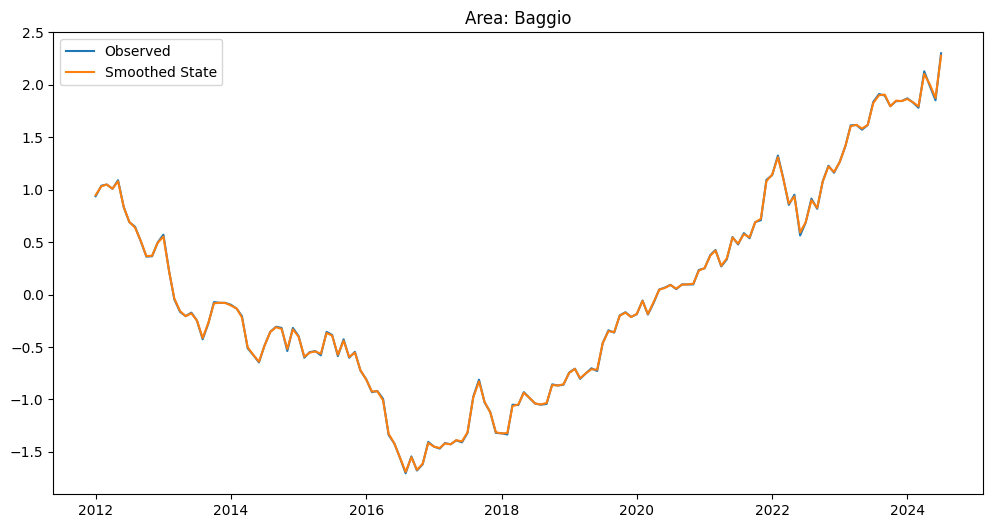

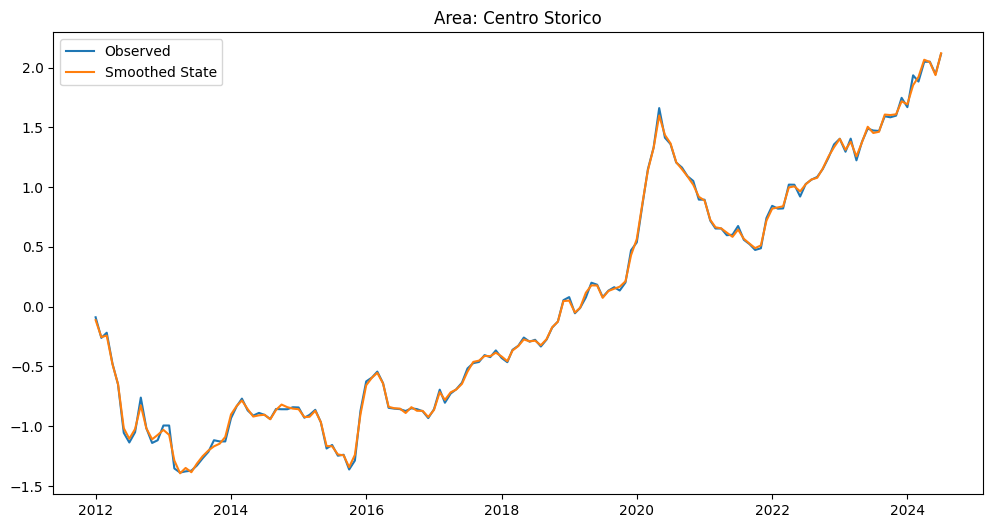

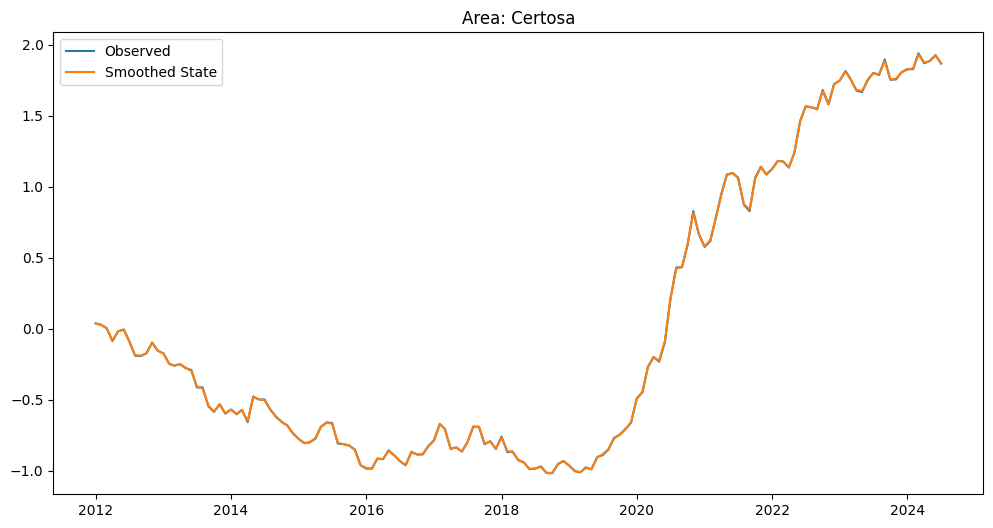

In [371]:
smoothed_states = result.smoothed_state.T

areas_to_plot = macro_areas[:3]
for idx, area in enumerate(areas_to_plot):
    plt.figure(figsize=(12, 6))
    plt.plot(pivot_df.index, endog_scaled[:, idx], label='Observed')
    plt.plot(pivot_df.index, smoothed_states[:, idx], label='Smoothed State')
    plt.title(f'Area: {area}')
    plt.legend()
    plt.show()


#### Impulse Response on SSM

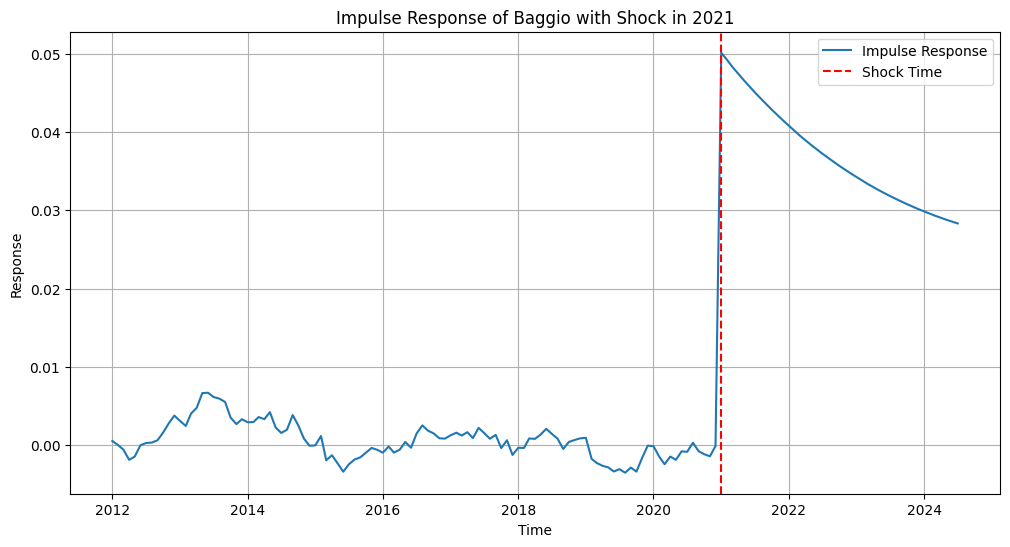

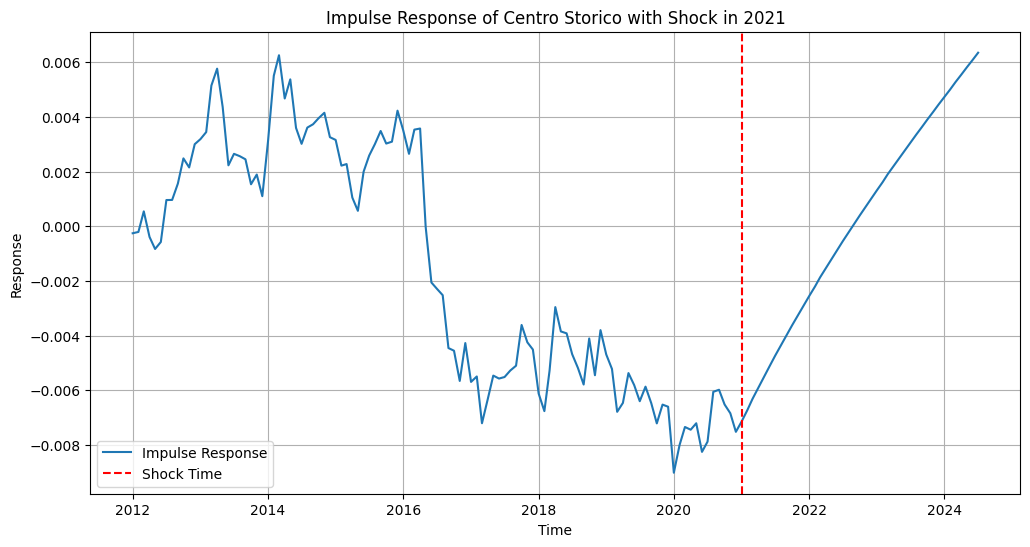

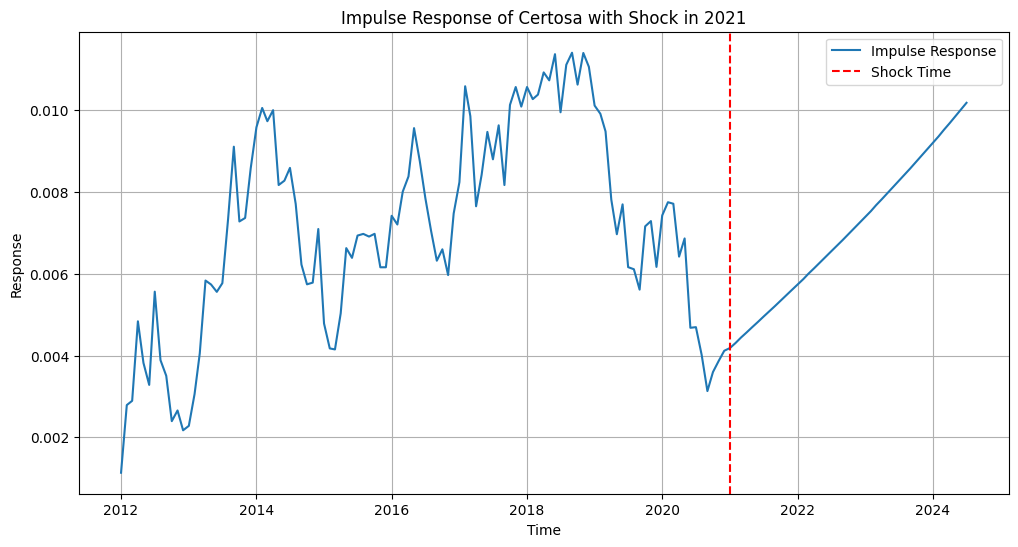

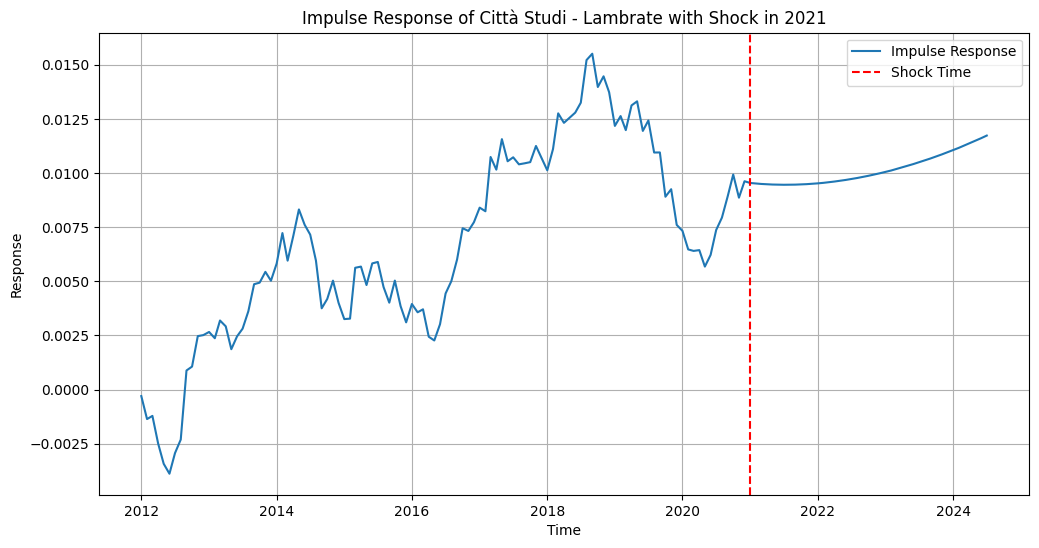

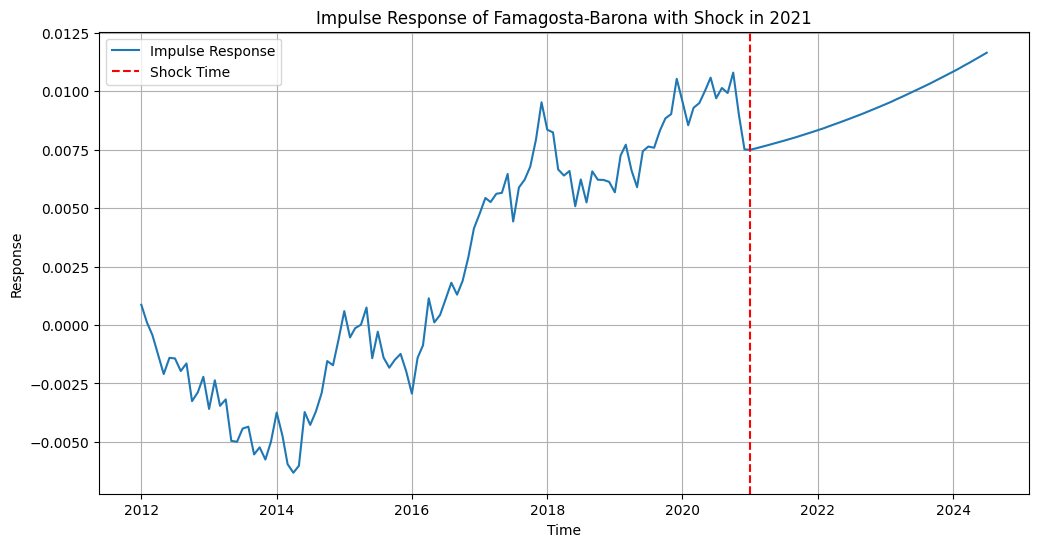

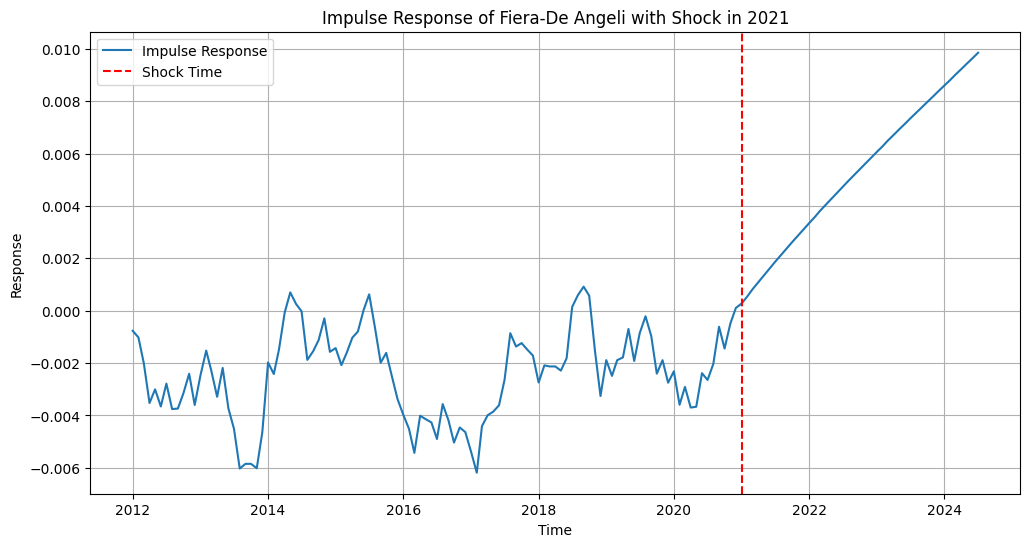

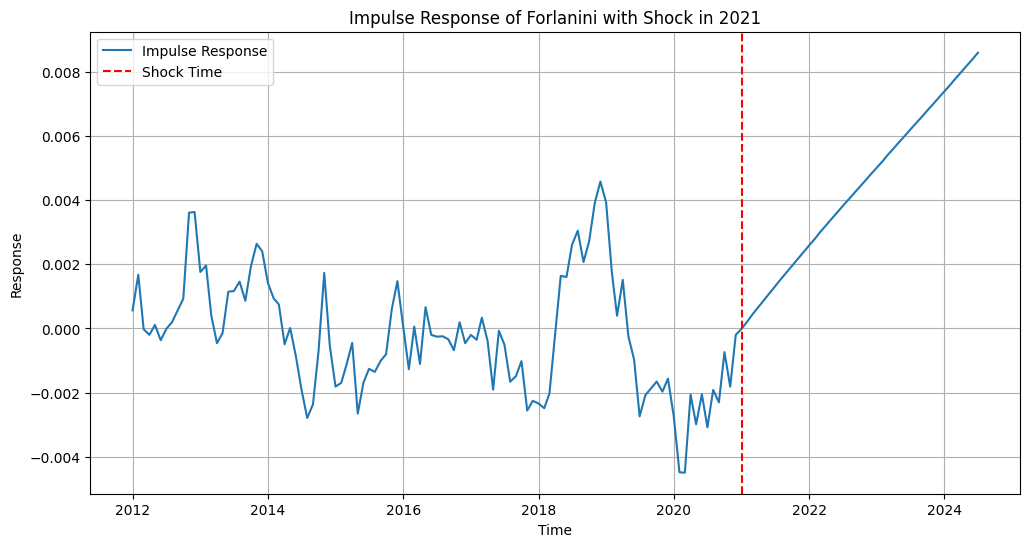

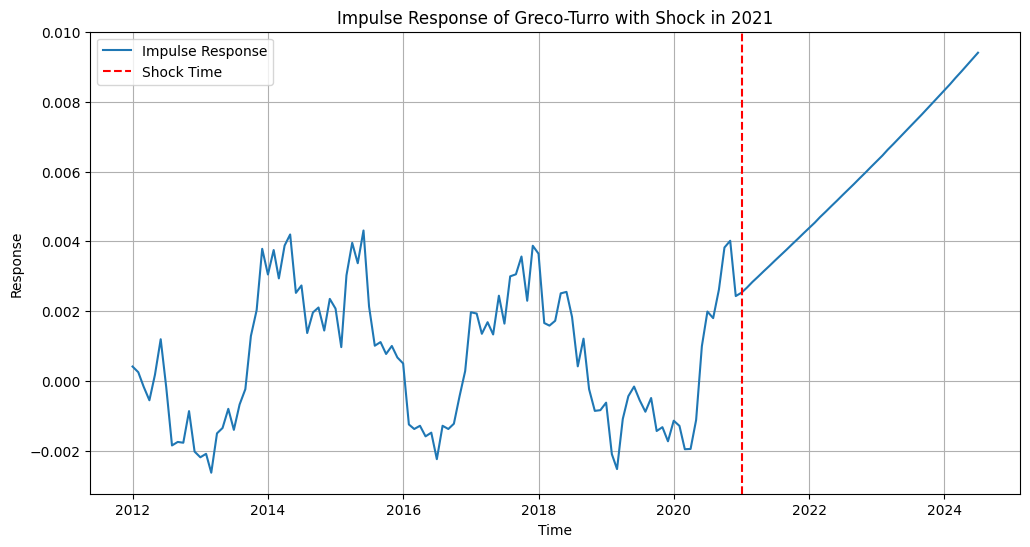

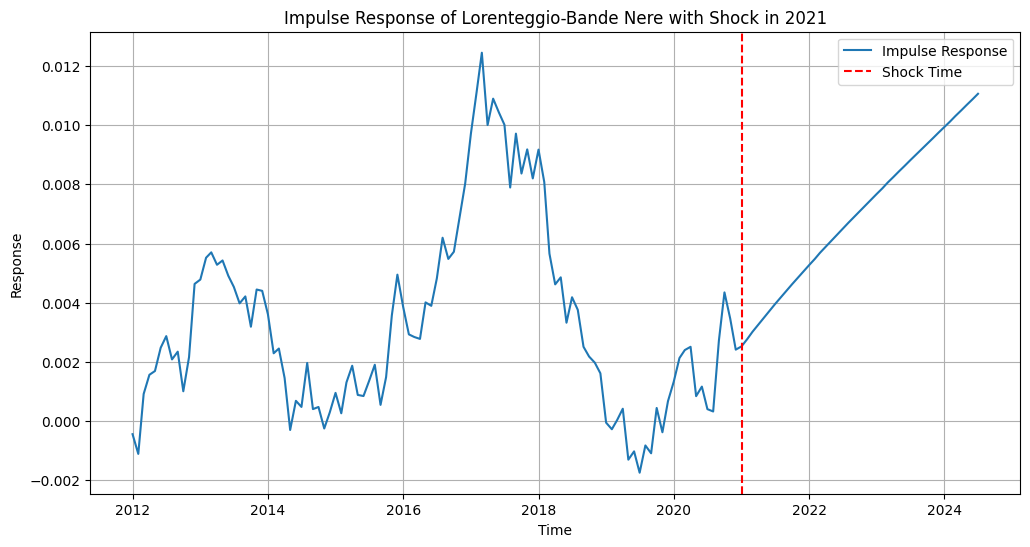

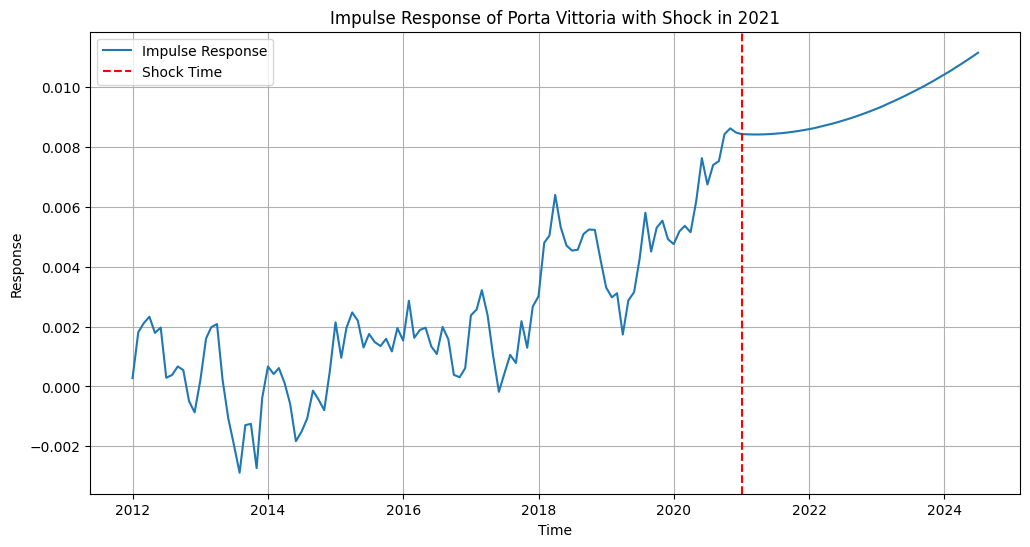

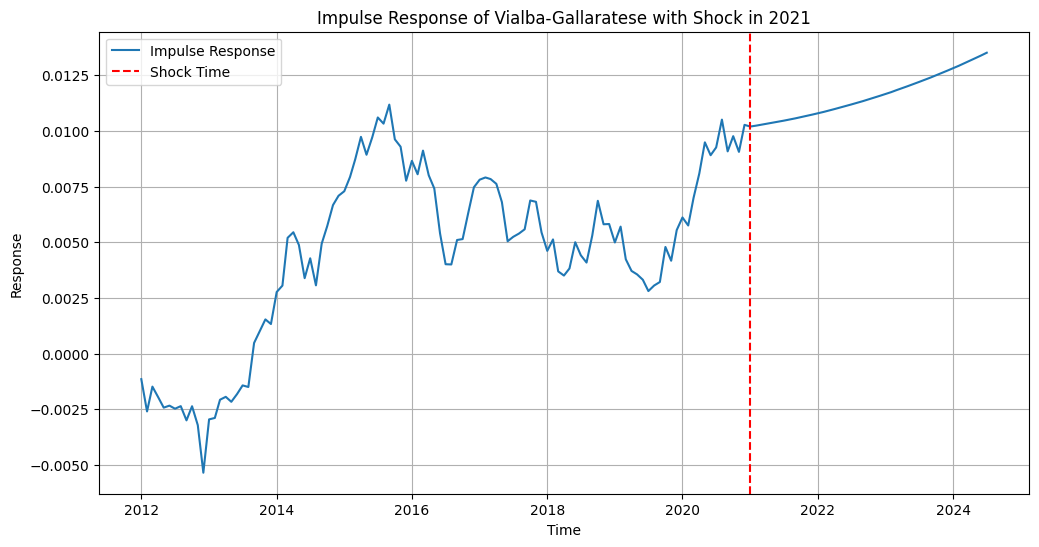

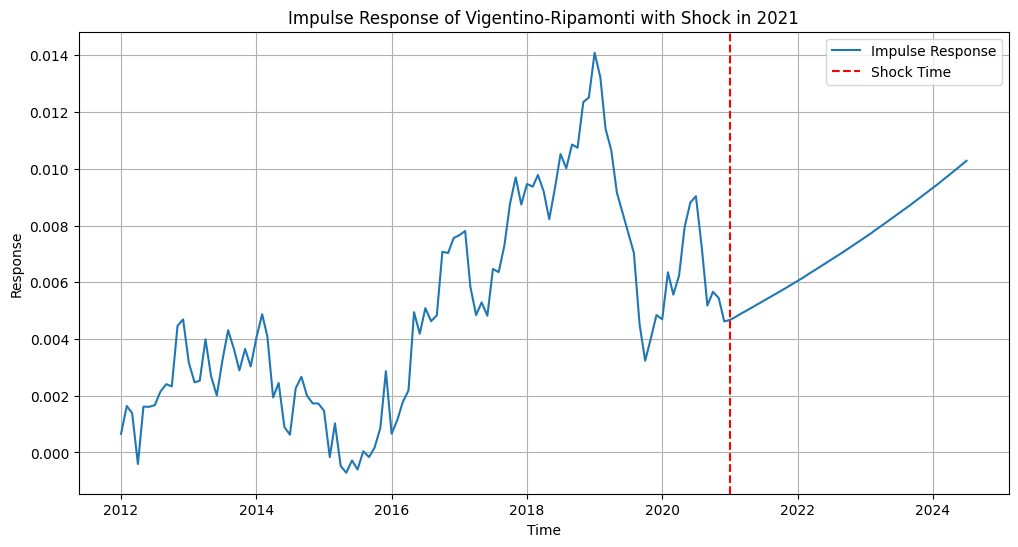

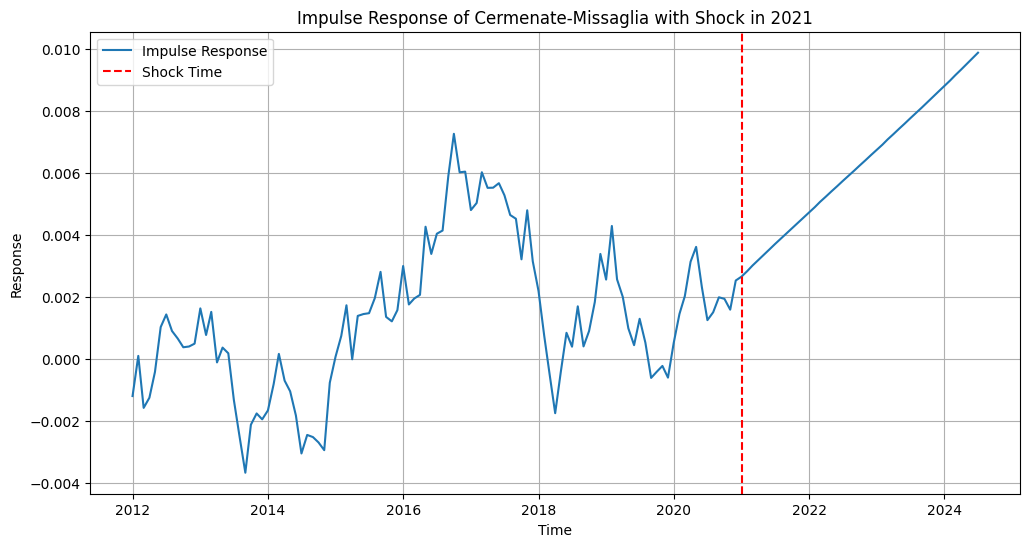

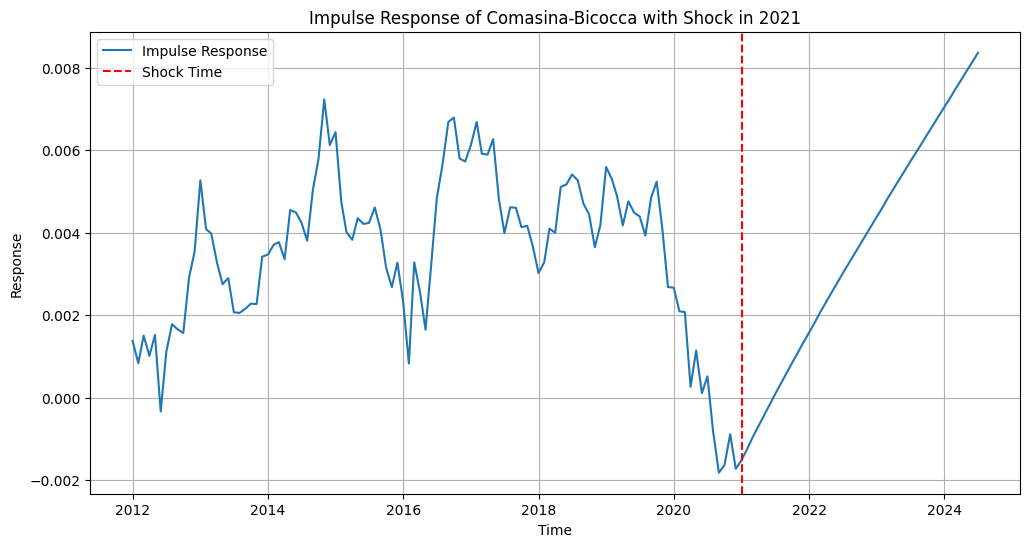

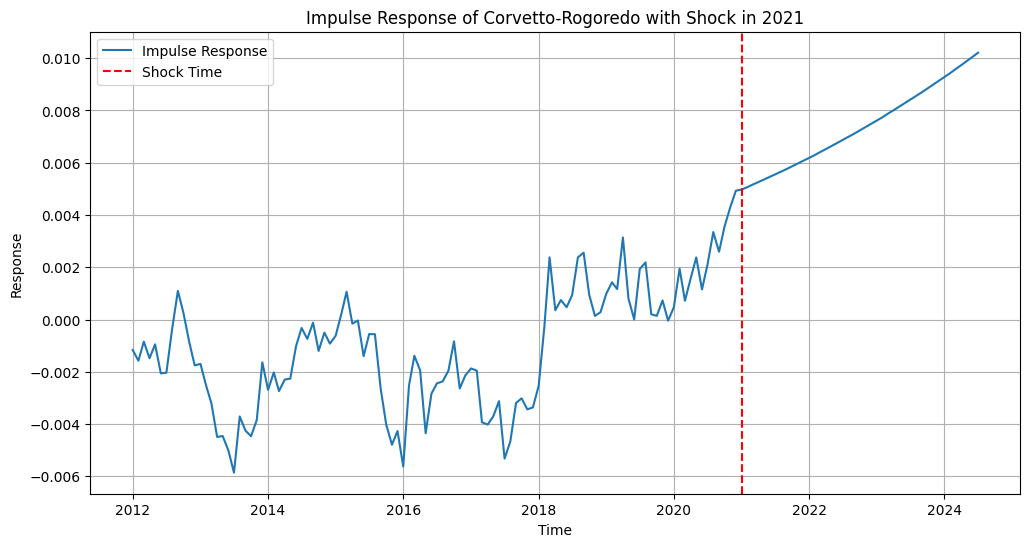

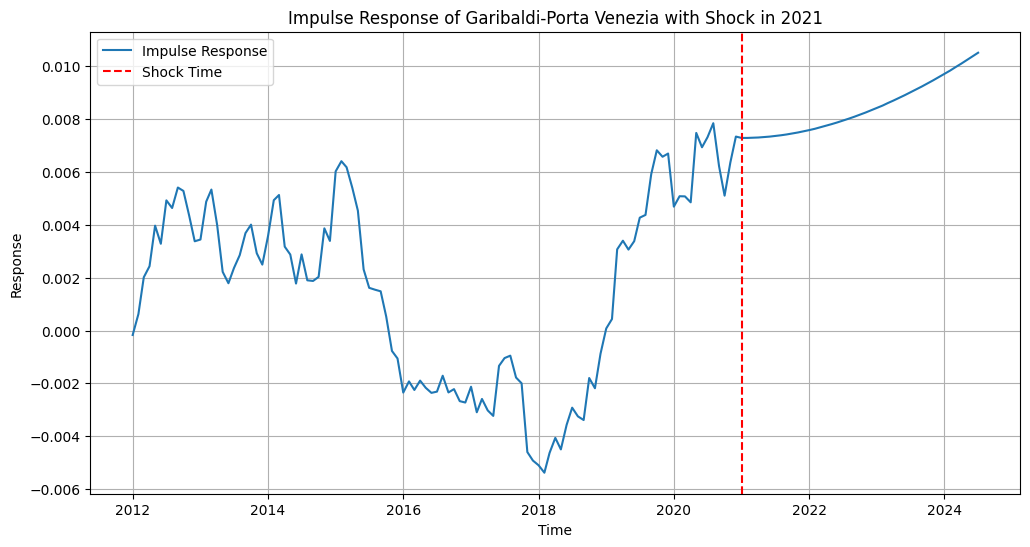

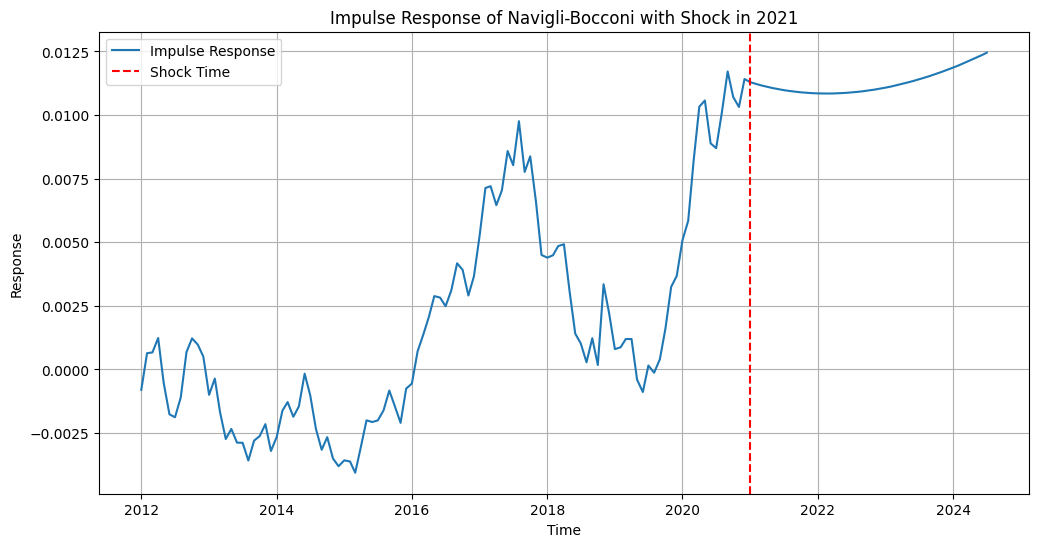

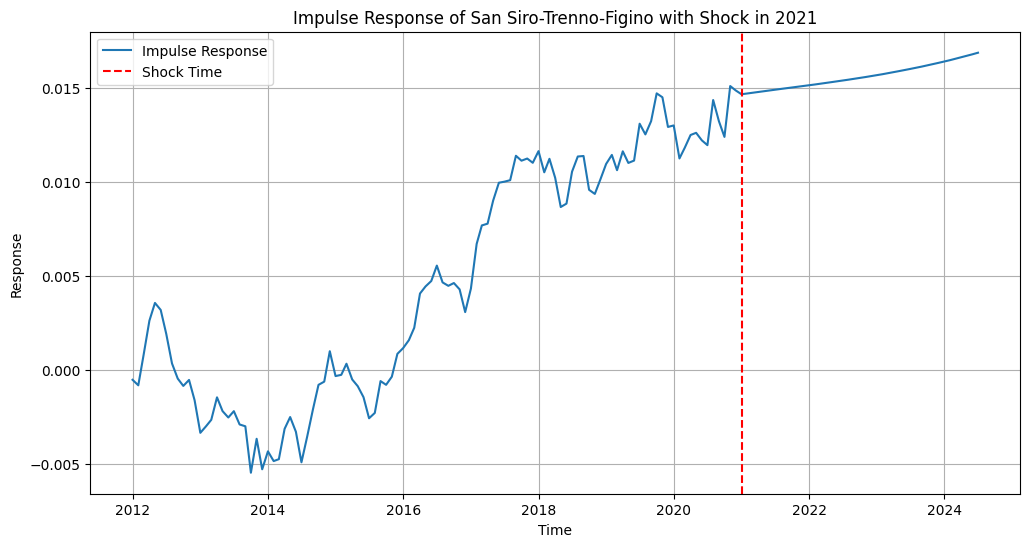

In [389]:
import numpy as np
import matplotlib.pyplot as plt

# Number of simulations
n_simulations = 1000

# Total number of time steps (length of the time series)
n_steps = len(pivot_df)

# Number of state variables
k_states = model.k_states

# Retrieve the estimated state transition matrix G
G = model.ssm['transition']

# Retrieve the state covariance matrix Q
Q = model.ssm['state_cov']

# Define the shock parameters
shock_state_index = 0  # Index of the state variable to shock
shock_magnitude = 0.05    # Adjust as needed

# Noise scaling factor
noise_scaling_factor = 1  # Adjust between 0 (no noise) and 1 (full noise)

# Find the index of the shock date
shock_date = '2021-01-01'  # Adjust the date as needed
shock_index = pivot_df.index.get_loc(shock_date)

# Initialize array to store the impulse responses for each simulation
irf_states_simulations = np.zeros((n_simulations, n_steps, k_states))

for sim in range(n_simulations):
    # Initialize the state at time 0
    theta_t = np.zeros((k_states, 1))
    
    irf_states = np.zeros((n_steps, k_states))
    
    for t in range(n_steps):
        # Apply the shock at the specified time index
        if t == shock_index:
            w_t = np.zeros((k_states, 1))
            w_t[shock_state_index, 0] = shock_magnitude
        elif t > shock_index:
            w_t = np.zeros((k_states, 1))  # No process noise after the shock
        else:
            w_t = np.random.multivariate_normal(mean=np.zeros(k_states), cov=Q).reshape(-1, 1)
            w_t *= noise_scaling_factor  # Scale down the noise before the shock if desired
        
        # Update the state
        theta_t = G @ theta_t + w_t
        
        # Store the state
        irf_states[t, :] = theta_t.flatten()
    
    # Store the simulation results
    irf_states_simulations[sim, :, :] = irf_states

# Compute the average impulse response over all simulations
irf_states_mean = np.mean(irf_states_simulations, axis=0)

# Plot the impulse responses with area names
for idx, area in enumerate(area_names):
    plt.figure(figsize=(12, 6))
    plt.plot(pivot_df.index, irf_states_mean[:, idx], label='Impulse Response')
    plt.axvline(x=pivot_df.index[shock_index], color='red', linestyle='--', label='Shock Time')
    plt.title(f'Impulse Response of {area} with Shock in 2021')
    plt.xlabel('Time')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True)
    plt.show()


### SSM + IRF - G GEOG DEPENDENCE

### Changes in Population

## Descriptive:

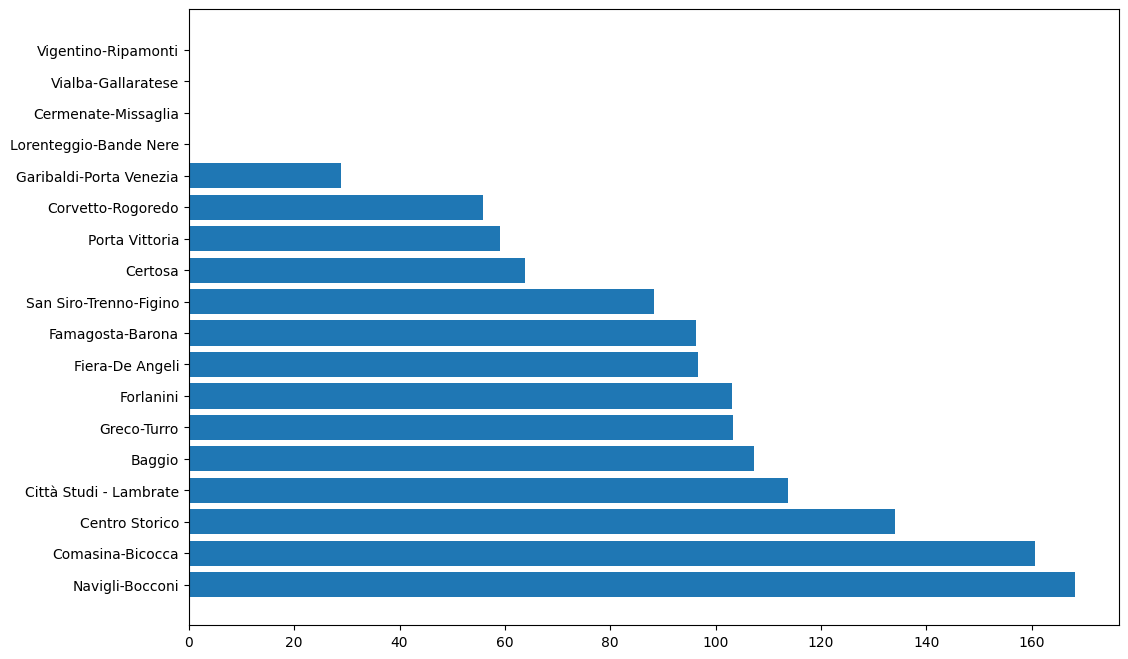

In [128]:
import matplotlib.pyplot as plt

_temp_health_vars = Sanità_relativa[["MacroArea","Cumulative Beds"]].copy()
summary_health = _temp_health_vars.groupby("MacroArea").mean()
summary_health = summary_health.sort_values(by="Cumulative Beds", ascending=False).reset_index().copy()
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(summary_health["MacroArea"],summary_health["Cumulative Beds"])
plt.show()


In [129]:
summary_prices = prices_full_table.groupby(by="NIL").mean()
summary_prices = summary_prices.sort_values(by="Prezzo m2", ascending=True).reset_index()
fig, ax = plt.subplots(figsize=(12,8))
ax.barh(summary_prices["NIL"], summary_prices["Prezzo m2"])
plt.show()

KeyError: 'NIL'

In [20]:
indep_vars.keys()

Index(['ANNO', 'NIL', 'CANC_VALUE', 'POP_VALUE', 'CANC_RATIO',
       'STRANIERI_NON_EU', 'STRANIERI_EU', 'EU_RATIO', 'NON_EU_RATIO',
       'FAMIGLIE', 'FAM_Ratio', 'NIL_normalized', 'MacroArea'],
      dtype='object')

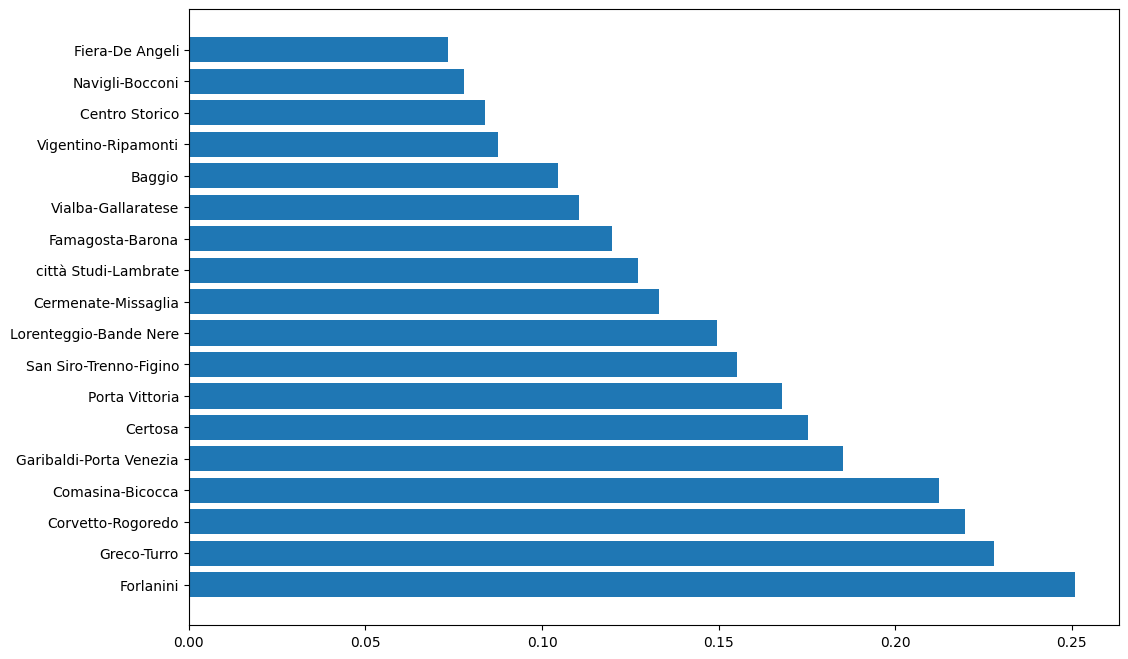

In [69]:
_temp_indep_vars = indep_vars[["MacroArea","NON_EU_RATIO"]].copy()
summary_indep = _temp_indep_vars.groupby("MacroArea").mean()
summary_indep = summary_indep.sort_values(by="NON_EU_RATIO", ascending=False).reset_index().copy()
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(summary_indep["MacroArea"],summary_indep["NON_EU_RATIO"])
plt.show()

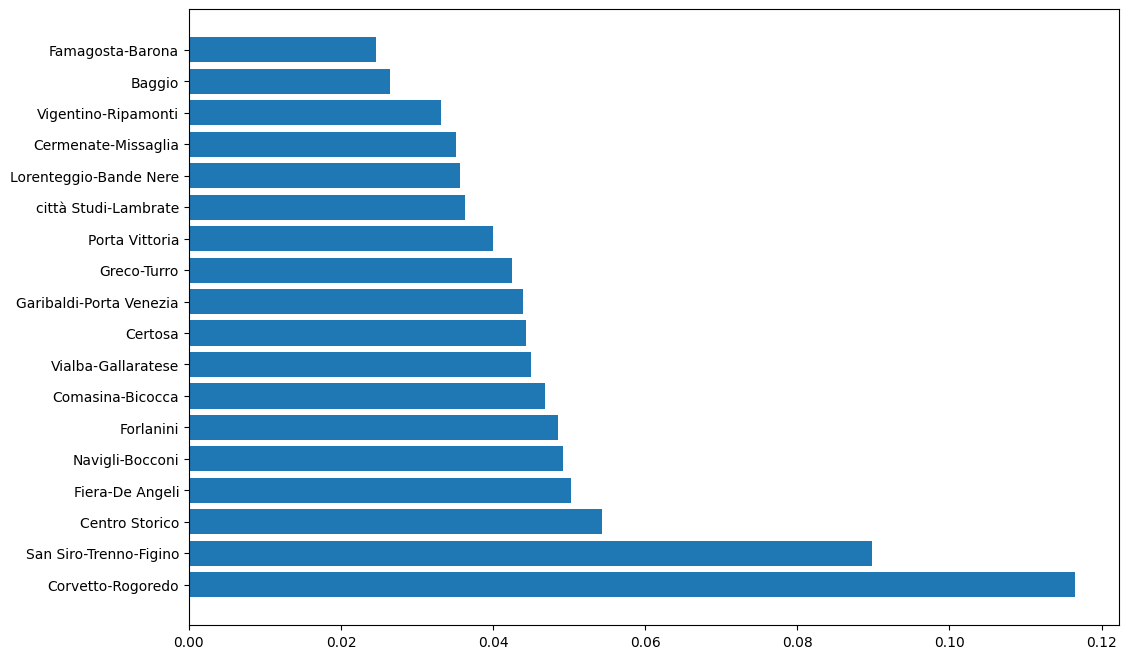

In [70]:
_temp_indep_vars = indep_vars[["MacroArea","EU_RATIO"]].copy()
summary_indep = _temp_indep_vars.groupby("MacroArea").mean()
summary_indep = summary_indep.sort_values(by="EU_RATIO", ascending=False).reset_index().copy()
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(summary_indep["MacroArea"],summary_indep["EU_RATIO"])
plt.show()

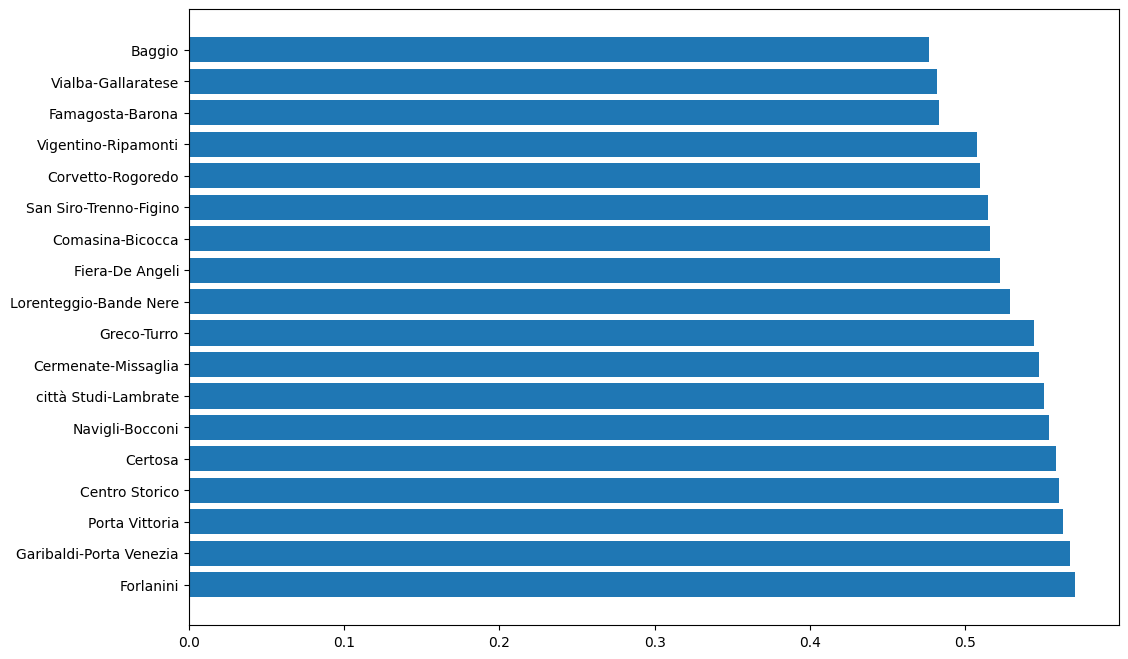

In [71]:
_temp_indep_vars = indep_vars[["MacroArea","FAM_Ratio"]].copy()
summary_indep = _temp_indep_vars.groupby("MacroArea").mean()
summary_indep = summary_indep.sort_values(by="FAM_Ratio", ascending=False).reset_index().copy()
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(summary_indep["MacroArea"],summary_indep["FAM_Ratio"])
plt.show()

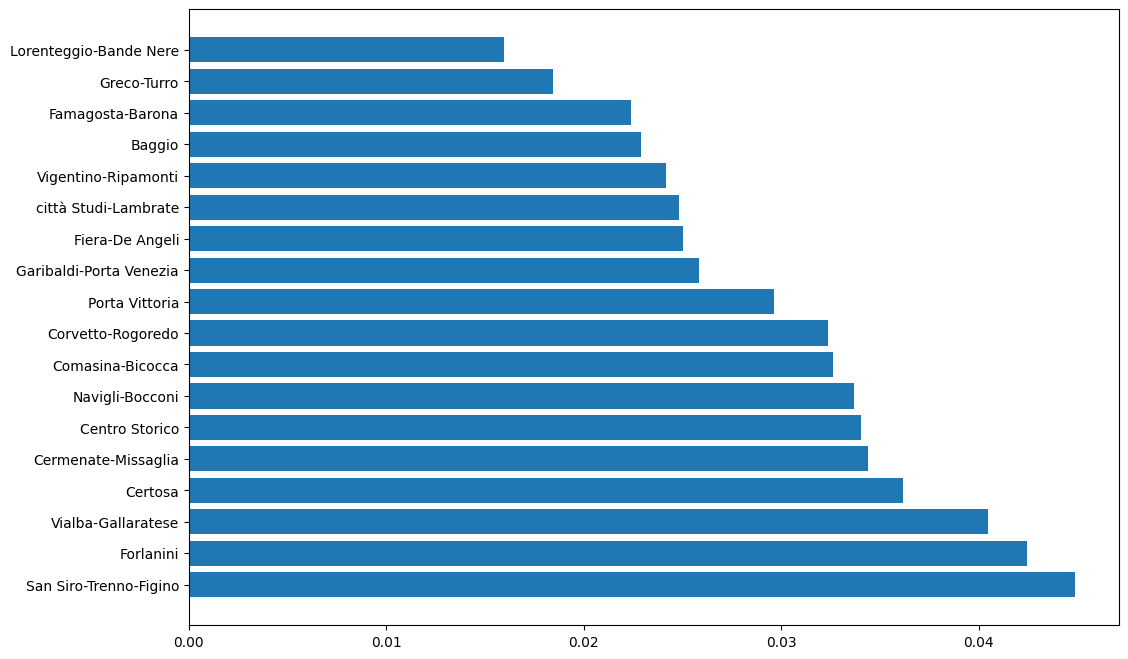

In [72]:
_temp_indep_vars = indep_vars[["MacroArea","CANC_RATIO"]].copy()
summary_indep = _temp_indep_vars.groupby("MacroArea").mean()
summary_indep = summary_indep.sort_values(by="CANC_RATIO", ascending=False).reset_index().copy()
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(summary_indep["MacroArea"],summary_indep["CANC_RATIO"])
plt.show()

In [40]:
indep_vars.keys()

Index(['ANNO', 'NIL', 'CANC_VALUE', 'POP_VALUE', 'CANC_RATIO',
       'STRANIERI_NON_EU', 'STRANIERI_EU', 'EU_RATIO', 'NON_EU_RATIO',
       'FAMIGLIE', 'FAM_Ratio', 'NIL_normalized', 'MacroArea'],
      dtype='object')